In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import io
import pickle
import json

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *
from encoder import *

In [2]:
# For this cell used same code from PyTorch notebook in assignment 2 of Stanford's CS231n Spring 2018 offering
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    dtype = torch.float32

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [3]:
# For this cell, code belongs to [1]. Minor changes made to accomodate to our use 
# (Using PyTorch instead of Keras/tensorflow)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

In [4]:
# Opening up json file that contains preprocessed images
with open('processedData.json') as f:
    data = json.load(f)

X_train = np.array(data['X_train'])
Y_train = np.array(data['Y_train'])
X_val = np.array(data['X_val'])
Y_val = np.array(data['Y_val'])
X_test = np.array(data['X_test'])
Y_test = np.array(data['Y_test'])

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


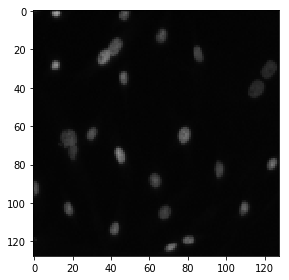

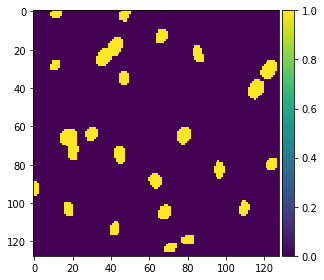

In [5]:
# Showing a training data point
y_reshaped = np.transpose(Y_train, (0,2,3,1))
x_reshaped = np.transpose(X_train, (0, 2, 3,1))
ix = np.random.randint(0, len(X_train))
imshow(np.uint8(x_reshaped[ix,:,:,:]))
plt.show()
imshow(np.squeeze(np.uint8(y_reshaped[ix,:,:,:])))
plt.show()

In [4]:
# This piece of code was borrowed from the Imagenet [7] github
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

In [5]:
# Reading imagenet data
imgnetX = []
imgnetY = []
for i in range(5):
    d = unpickle('train_data_batch_'+str(i+1))
    imgnetX.append(d['data'])
    imgnetY.append(d['labels'])

In [6]:
# Reshaping imgnetY such that shape is (N,)
imgnetY = np.array(imgnetY)
imgnetY = imgnetY.reshape((imgnetY.shape[0]*imgnetY.shape[1],))
print('Shape of imgnetY = ', str(imgnetY.shape))

Shape of imgnetY =  (640580,)


In [7]:
# Reshaping imgnetX from (numDataBatches, dataBatchSize, img_size*img_size*3)
# to (N, 3, img_size, img_size)
# Two lines borrowed from [7]
imgnetX = np.array(imgnetX)
imgnetX = imgnetX.reshape((imgnetX.shape[0]*imgnetX.shape[1], imgnetX.shape[2]))
imgnetX = np.dstack((imgnetX[:, :4096], imgnetX[:, 4096:8192], imgnetX[:, 8192:]))
imgnetX = imgnetX.reshape((imgnetX.shape[0], 64, 64, 3)).transpose(0, 3, 1, 2)

print('Shape of imgnetX = ', str(imgnetX.shape))

Shape of imgnetX =  (640580, 3, 64, 64)


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


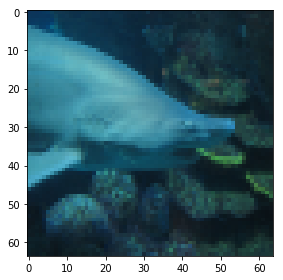

In [7]:
# Let us visualize a training sample
x_reshaped = np.transpose(imgnetX, (0, 2, 3,1))
ix = np.random.randint(0, len(imgnetX))
imshow(np.uint8(x_reshaped[ix,:,:,:]))
plt.show()

In [11]:
tempY = imgnetY[1450:1500]
expandedY = np.zeros((tempY.shape[0], 1000))
expandedY[np.arange(50), tempY-1] = 1
print(np.argmax(expandedY, axis = 1)[46])

999


In [9]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64):
    model.eval() #set model to evaluation mode
    numCorrect = 0
    num_batches = int(X_perf.shape[0]/mini_batch_size)
    num_remaining = X_perf.shape[0] - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            x = x.to(device = device, dtype = dtype)
            preds = model(x).cpu().numpy()
            preds = np.argmax(preds, axis = 1) + 1
            numCorrect += np.sum(preds == Y_perf[i*mini_batch_size:(i+1)*mini_batch_size])
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        x = x.to(device = device, dtype = dtype)
        preds = model(x).cpu().numpy()
        preds = np.argmax(preds, axis = 1) + 1
        numCorrect += np.sum(preds == Y_perf[num_batches*mini_batch_size:])
    return numCorrect/(int(X_perf.shape[0]))

In [10]:
def trainEncoder(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(x_train.shape[0]/mini_batch_size)
    num_remaining = x_train.shape[0] - num_batches *mini_batch_size
    loss_history = []
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(x_train.shape[0], mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices] - 1) # cross_entropy fn expects 0<= y[i] <=C-1
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.cross_entropy(preds, y.type(torch.long))

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, currLoss))
            if (num_remaining <= 0 and t == (num_batches -1)):
                percCorrect = calculatePerformance(x_train, y_train, model)
                print('Train percentage at epoch %d is %.4f' % (e, percCorrect))
                if (noVal == False):
                    percCorrect = calculatePerformance(x_val, y_val, model)
                    print('Train percentage at epoch %d is %.4f' % (e, percCorrect))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices] -1)
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.cross_entropy(preds, y.type(torch.long))

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, num_batches, currLoss))
            percCorrect = calculatePerformance(x_train, y_train, model)
            print('Train percentage at epoch %d is %.4f' % (e, percCorrect))
            if (noVal == False):
                percCorrect = calculatePerformance(x_val, y_val, model)
                print('Val percentage at epoch %d is %.4f' % (e, percCorrect))
            T +=1
    return calculatePerformance(x_train, y_train, model),loss_history

In [26]:
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
x_train =imgnetX[:5000,:,:,:]
y_train = imgnetY[:5000]
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
for lr in lrs:
    print('Below result for lr = ', str(lr))
    model = encoderNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf, lossHistory = trainEncoder(model, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = model
        lrUsed = lr

Shape of x_train =  (5000, 3, 64, 64)
Shape of y_train =  (5000,)
Below result for lr =  0.01
Epoch 0, Iteration 0, loss = 335.6196
Epoch 0, Iteration 1, loss = 6.9070
Epoch 0, Iteration 2, loss = 6.9096
Epoch 0, Iteration 3, loss = 6.9065
Epoch 0, Iteration 4, loss = 6.9078
Epoch 0, Iteration 5, loss = 6.9043
Epoch 0, Iteration 6, loss = 6.9063
Epoch 0, Iteration 7, loss = 6.9030
Epoch 0, Iteration 8, loss = 6.9069
Epoch 0, Iteration 9, loss = 6.9035
Epoch 0, Iteration 10, loss = 6.9106
Epoch 0, Iteration 11, loss = 6.9043
Epoch 0, Iteration 12, loss = 6.9099
Epoch 0, Iteration 13, loss = 6.8883
Epoch 0, Iteration 14, loss = 6.8936
Epoch 0, Iteration 15, loss = 6.8999
Epoch 0, Iteration 16, loss = 6.8940
Epoch 0, Iteration 17, loss = 6.9007
Epoch 0, Iteration 18, loss = 6.9017
Epoch 0, Iteration 19, loss = 6.8896
Epoch 0, Iteration 20, loss = 6.8894
Epoch 0, Iteration 21, loss = 6.8957
Epoch 0, Iteration 22, loss = 6.9023
Epoch 0, Iteration 23, loss = 6.9155
Epoch 0, Iteration 24, los

Epoch 2, Iteration 61, loss = 6.8751
Epoch 2, Iteration 62, loss = 6.9332
Epoch 2, Iteration 63, loss = 6.8712
Epoch 2, Iteration 64, loss = 6.8639
Epoch 2, Iteration 65, loss = 6.8111
Epoch 2, Iteration 66, loss = 6.8385
Epoch 2, Iteration 67, loss = 6.8421
Epoch 2, Iteration 68, loss = 6.8808
Epoch 2, Iteration 69, loss = 6.8447
Epoch 2, Iteration 70, loss = 6.8039
Epoch 2, Iteration 71, loss = 6.8942
Epoch 2, Iteration 72, loss = 6.8355
Epoch 2, Iteration 73, loss = 6.8557
Epoch 2, Iteration 74, loss = 6.7923
Epoch 2, Iteration 75, loss = 6.8157
Epoch 2, Iteration 76, loss = 6.8545
Epoch 2, Iteration 77, loss = 6.8810
Epoch 2, Iteration 78, loss = 6.9452
Train percentage at epoch 2 is 0.0028
Epoch 3, Iteration 0, loss = 6.8281
Epoch 3, Iteration 1, loss = 6.7979
Epoch 3, Iteration 2, loss = 6.8653
Epoch 3, Iteration 3, loss = 6.9545
Epoch 3, Iteration 4, loss = 6.8023
Epoch 3, Iteration 5, loss = 6.8114
Epoch 3, Iteration 6, loss = 6.8264
Epoch 3, Iteration 7, loss = 6.8352
Epoch 3,

Epoch 5, Iteration 45, loss = 6.8774
Epoch 5, Iteration 46, loss = 6.8645
Epoch 5, Iteration 47, loss = 6.9333
Epoch 5, Iteration 48, loss = 6.7788
Epoch 5, Iteration 49, loss = 6.8744
Epoch 5, Iteration 50, loss = 6.8027
Epoch 5, Iteration 51, loss = 6.8444
Epoch 5, Iteration 52, loss = 6.7995
Epoch 5, Iteration 53, loss = 6.8192
Epoch 5, Iteration 54, loss = 6.7916
Epoch 5, Iteration 55, loss = 6.8249
Epoch 5, Iteration 56, loss = 6.8787
Epoch 5, Iteration 57, loss = 6.8169
Epoch 5, Iteration 58, loss = 6.8096
Epoch 5, Iteration 59, loss = 6.8256
Epoch 5, Iteration 60, loss = 6.8889
Epoch 5, Iteration 61, loss = 6.7938
Epoch 5, Iteration 62, loss = 6.8482
Epoch 5, Iteration 63, loss = 6.8474
Epoch 5, Iteration 64, loss = 6.8683
Epoch 5, Iteration 65, loss = 6.8419
Epoch 5, Iteration 66, loss = 6.7976
Epoch 5, Iteration 67, loss = 6.8855
Epoch 5, Iteration 68, loss = 6.7638
Epoch 5, Iteration 69, loss = 6.7798
Epoch 5, Iteration 70, loss = 6.7838
Epoch 5, Iteration 71, loss = 6.8468
E

Epoch 8, Iteration 29, loss = 6.8143
Epoch 8, Iteration 30, loss = 6.8330
Epoch 8, Iteration 31, loss = 6.8542
Epoch 8, Iteration 32, loss = 6.7326
Epoch 8, Iteration 33, loss = 6.8194
Epoch 8, Iteration 34, loss = 6.8562
Epoch 8, Iteration 35, loss = 6.7895
Epoch 8, Iteration 36, loss = 6.8726
Epoch 8, Iteration 37, loss = 6.7827
Epoch 8, Iteration 38, loss = 6.8383
Epoch 8, Iteration 39, loss = 6.8418
Epoch 8, Iteration 40, loss = 6.7696
Epoch 8, Iteration 41, loss = 6.8234
Epoch 8, Iteration 42, loss = 6.7540
Epoch 8, Iteration 43, loss = 6.7360
Epoch 8, Iteration 44, loss = 6.8145
Epoch 8, Iteration 45, loss = 6.8258
Epoch 8, Iteration 46, loss = 6.8263
Epoch 8, Iteration 47, loss = 6.8098
Epoch 8, Iteration 48, loss = 6.8993
Epoch 8, Iteration 49, loss = 6.7905
Epoch 8, Iteration 50, loss = 6.7768
Epoch 8, Iteration 51, loss = 6.8285
Epoch 8, Iteration 52, loss = 6.7526
Epoch 8, Iteration 53, loss = 6.7743
Epoch 8, Iteration 54, loss = 6.7202
Epoch 8, Iteration 55, loss = 6.8304
E

Epoch 11, Iteration 9, loss = 6.7621
Epoch 11, Iteration 10, loss = 6.7085
Epoch 11, Iteration 11, loss = 6.8667
Epoch 11, Iteration 12, loss = 6.7514
Epoch 11, Iteration 13, loss = 6.7681
Epoch 11, Iteration 14, loss = 6.8175
Epoch 11, Iteration 15, loss = 6.8196
Epoch 11, Iteration 16, loss = 6.8685
Epoch 11, Iteration 17, loss = 6.8837
Epoch 11, Iteration 18, loss = 6.8612
Epoch 11, Iteration 19, loss = 6.7826
Epoch 11, Iteration 20, loss = 6.7743
Epoch 11, Iteration 21, loss = 6.7910
Epoch 11, Iteration 22, loss = 6.8368
Epoch 11, Iteration 23, loss = 6.8440
Epoch 11, Iteration 24, loss = 6.8723
Epoch 11, Iteration 25, loss = 6.7733
Epoch 11, Iteration 26, loss = 6.9126
Epoch 11, Iteration 27, loss = 6.8956
Epoch 11, Iteration 28, loss = 6.8063
Epoch 11, Iteration 29, loss = 6.8540
Epoch 11, Iteration 30, loss = 6.8339
Epoch 11, Iteration 31, loss = 6.7241
Epoch 11, Iteration 32, loss = 6.7899
Epoch 11, Iteration 33, loss = 6.8490
Epoch 11, Iteration 34, loss = 6.7562
Epoch 11, Ite

Epoch 13, Iteration 67, loss = 6.7496
Epoch 13, Iteration 68, loss = 6.8149
Epoch 13, Iteration 69, loss = 6.8311
Epoch 13, Iteration 70, loss = 6.8103
Epoch 13, Iteration 71, loss = 6.7791
Epoch 13, Iteration 72, loss = 6.7616
Epoch 13, Iteration 73, loss = 6.8810
Epoch 13, Iteration 74, loss = 6.7549
Epoch 13, Iteration 75, loss = 6.7712
Epoch 13, Iteration 76, loss = 6.8665
Epoch 13, Iteration 77, loss = 6.8330
Epoch 13, Iteration 78, loss = 6.7866
Train percentage at epoch 13 is 0.0028
Epoch 14, Iteration 0, loss = 6.7913
Epoch 14, Iteration 1, loss = 6.8928
Epoch 14, Iteration 2, loss = 6.8787
Epoch 14, Iteration 3, loss = 6.7945
Epoch 14, Iteration 4, loss = 6.7616
Epoch 14, Iteration 5, loss = 6.8811
Epoch 14, Iteration 6, loss = 6.8276
Epoch 14, Iteration 7, loss = 6.7547
Epoch 14, Iteration 8, loss = 6.9123
Epoch 14, Iteration 9, loss = 6.8657
Epoch 14, Iteration 10, loss = 6.8314
Epoch 14, Iteration 11, loss = 6.7889
Epoch 14, Iteration 12, loss = 6.8139
Epoch 14, Iteration 1

Epoch 16, Iteration 45, loss = 6.7973
Epoch 16, Iteration 46, loss = 6.8711
Epoch 16, Iteration 47, loss = 6.8893
Epoch 16, Iteration 48, loss = 6.8190
Epoch 16, Iteration 49, loss = 6.7825
Epoch 16, Iteration 50, loss = 6.8985
Epoch 16, Iteration 51, loss = 6.8454
Epoch 16, Iteration 52, loss = 6.8974
Epoch 16, Iteration 53, loss = 6.8307
Epoch 16, Iteration 54, loss = 6.7790
Epoch 16, Iteration 55, loss = 6.8199
Epoch 16, Iteration 56, loss = 6.8429
Epoch 16, Iteration 57, loss = 6.8749
Epoch 16, Iteration 58, loss = 6.8225
Epoch 16, Iteration 59, loss = 6.8191
Epoch 16, Iteration 60, loss = 6.7811
Epoch 16, Iteration 61, loss = 6.8654
Epoch 16, Iteration 62, loss = 6.8623
Epoch 16, Iteration 63, loss = 6.9243
Epoch 16, Iteration 64, loss = 6.8507
Epoch 16, Iteration 65, loss = 6.7500
Epoch 16, Iteration 66, loss = 6.8197
Epoch 16, Iteration 67, loss = 6.7641
Epoch 16, Iteration 68, loss = 6.7409
Epoch 16, Iteration 69, loss = 6.8648
Epoch 16, Iteration 70, loss = 6.8558
Epoch 16, It

Epoch 19, Iteration 23, loss = 6.7812
Epoch 19, Iteration 24, loss = 6.8242
Epoch 19, Iteration 25, loss = 6.7615
Epoch 19, Iteration 26, loss = 6.8242
Epoch 19, Iteration 27, loss = 6.7640
Epoch 19, Iteration 28, loss = 6.8682
Epoch 19, Iteration 29, loss = 6.7809
Epoch 19, Iteration 30, loss = 6.9043
Epoch 19, Iteration 31, loss = 6.7632
Epoch 19, Iteration 32, loss = 6.8055
Epoch 19, Iteration 33, loss = 6.8576
Epoch 19, Iteration 34, loss = 6.8991
Epoch 19, Iteration 35, loss = 6.8618
Epoch 19, Iteration 36, loss = 6.8196
Epoch 19, Iteration 37, loss = 6.8712
Epoch 19, Iteration 38, loss = 6.8691
Epoch 19, Iteration 39, loss = 6.8327
Epoch 19, Iteration 40, loss = 6.9529
Epoch 19, Iteration 41, loss = 6.9200
Epoch 19, Iteration 42, loss = 6.7769
Epoch 19, Iteration 43, loss = 6.7823
Epoch 19, Iteration 44, loss = 6.7499
Epoch 19, Iteration 45, loss = 6.8102
Epoch 19, Iteration 46, loss = 6.9009
Epoch 19, Iteration 47, loss = 6.8061
Epoch 19, Iteration 48, loss = 6.7986
Epoch 19, It

Epoch 22, Iteration 1, loss = 6.7757
Epoch 22, Iteration 2, loss = 6.7626
Epoch 22, Iteration 3, loss = 6.7505
Epoch 22, Iteration 4, loss = 6.8769
Epoch 22, Iteration 5, loss = 6.8592
Epoch 22, Iteration 6, loss = 6.9031
Epoch 22, Iteration 7, loss = 6.7613
Epoch 22, Iteration 8, loss = 6.8530
Epoch 22, Iteration 9, loss = 6.7227
Epoch 22, Iteration 10, loss = 6.7865
Epoch 22, Iteration 11, loss = 6.8460
Epoch 22, Iteration 12, loss = 6.7635
Epoch 22, Iteration 13, loss = 6.8639
Epoch 22, Iteration 14, loss = 6.7939
Epoch 22, Iteration 15, loss = 6.8475
Epoch 22, Iteration 16, loss = 6.8652
Epoch 22, Iteration 17, loss = 6.8174
Epoch 22, Iteration 18, loss = 6.8319
Epoch 22, Iteration 19, loss = 6.9098
Epoch 22, Iteration 20, loss = 6.8856
Epoch 22, Iteration 21, loss = 6.8161
Epoch 22, Iteration 22, loss = 6.8420
Epoch 22, Iteration 23, loss = 6.8454
Epoch 22, Iteration 24, loss = 6.7091
Epoch 22, Iteration 25, loss = 6.7977
Epoch 22, Iteration 26, loss = 6.8554
Epoch 22, Iteration 2

Epoch 24, Iteration 59, loss = 6.8055
Epoch 24, Iteration 60, loss = 6.7934
Epoch 24, Iteration 61, loss = 6.8387
Epoch 24, Iteration 62, loss = 6.8220
Epoch 24, Iteration 63, loss = 6.8111
Epoch 24, Iteration 64, loss = 6.8218
Epoch 24, Iteration 65, loss = 6.8836
Epoch 24, Iteration 66, loss = 6.8149
Epoch 24, Iteration 67, loss = 6.8537
Epoch 24, Iteration 68, loss = 6.8207
Epoch 24, Iteration 69, loss = 6.7838
Epoch 24, Iteration 70, loss = 6.7638
Epoch 24, Iteration 71, loss = 6.8229
Epoch 24, Iteration 72, loss = 6.7628
Epoch 24, Iteration 73, loss = 6.7764
Epoch 24, Iteration 74, loss = 6.8562
Epoch 24, Iteration 75, loss = 6.7307
Epoch 24, Iteration 76, loss = 6.7959
Epoch 24, Iteration 77, loss = 6.7545
Epoch 24, Iteration 78, loss = 6.6590
Train percentage at epoch 24 is 0.0028
Below result for lr =  0.001
Epoch 0, Iteration 0, loss = 2285.8306
Epoch 0, Iteration 1, loss = 1053.1577
Epoch 0, Iteration 2, loss = 567.2410
Epoch 0, Iteration 3, loss = 252.9112
Epoch 0, Iteration

Epoch 2, Iteration 41, loss = 6.8224
Epoch 2, Iteration 42, loss = 6.8268
Epoch 2, Iteration 43, loss = 6.8858
Epoch 2, Iteration 44, loss = 6.8929
Epoch 2, Iteration 45, loss = 6.7382
Epoch 2, Iteration 46, loss = 6.7861
Epoch 2, Iteration 47, loss = 6.7673
Epoch 2, Iteration 48, loss = 6.8251
Epoch 2, Iteration 49, loss = 6.7322
Epoch 2, Iteration 50, loss = 6.8470
Epoch 2, Iteration 51, loss = 6.7649
Epoch 2, Iteration 52, loss = 6.8923
Epoch 2, Iteration 53, loss = 6.8823
Epoch 2, Iteration 54, loss = 6.9713
Epoch 2, Iteration 55, loss = 6.8236
Epoch 2, Iteration 56, loss = 6.8494
Epoch 2, Iteration 57, loss = 6.8746
Epoch 2, Iteration 58, loss = 6.8761
Epoch 2, Iteration 59, loss = 6.7557
Epoch 2, Iteration 60, loss = 6.8461
Epoch 2, Iteration 61, loss = 6.8632
Epoch 2, Iteration 62, loss = 6.7021
Epoch 2, Iteration 63, loss = 6.7775
Epoch 2, Iteration 64, loss = 6.8407
Epoch 2, Iteration 65, loss = 6.8403
Epoch 2, Iteration 66, loss = 6.7064
Epoch 2, Iteration 67, loss = 6.7582
E

Epoch 5, Iteration 25, loss = 6.5404
Epoch 5, Iteration 26, loss = 6.5606
Epoch 5, Iteration 27, loss = 6.7129
Epoch 5, Iteration 28, loss = 6.5452
Epoch 5, Iteration 29, loss = 6.5047
Epoch 5, Iteration 30, loss = 6.7069
Epoch 5, Iteration 31, loss = 6.6350
Epoch 5, Iteration 32, loss = 6.6370
Epoch 5, Iteration 33, loss = 6.3402
Epoch 5, Iteration 34, loss = 6.3088
Epoch 5, Iteration 35, loss = 6.8122
Epoch 5, Iteration 36, loss = 6.6842
Epoch 5, Iteration 37, loss = 6.6079
Epoch 5, Iteration 38, loss = 6.6499
Epoch 5, Iteration 39, loss = 6.8297
Epoch 5, Iteration 40, loss = 6.6879
Epoch 5, Iteration 41, loss = 6.9000
Epoch 5, Iteration 42, loss = 6.6592
Epoch 5, Iteration 43, loss = 6.4613
Epoch 5, Iteration 44, loss = 6.6203
Epoch 5, Iteration 45, loss = 6.5854
Epoch 5, Iteration 46, loss = 6.4916
Epoch 5, Iteration 47, loss = 6.4488
Epoch 5, Iteration 48, loss = 6.7271
Epoch 5, Iteration 49, loss = 6.5216
Epoch 5, Iteration 50, loss = 6.4229
Epoch 5, Iteration 51, loss = 6.6014
E

Epoch 8, Iteration 9, loss = 6.5249
Epoch 8, Iteration 10, loss = 6.0538
Epoch 8, Iteration 11, loss = 6.3528
Epoch 8, Iteration 12, loss = 6.3745
Epoch 8, Iteration 13, loss = 6.9384
Epoch 8, Iteration 14, loss = 6.7237
Epoch 8, Iteration 15, loss = 6.3915
Epoch 8, Iteration 16, loss = 6.3522
Epoch 8, Iteration 17, loss = 6.4164
Epoch 8, Iteration 18, loss = 6.2802
Epoch 8, Iteration 19, loss = 6.5564
Epoch 8, Iteration 20, loss = 6.7048
Epoch 8, Iteration 21, loss = 6.5171
Epoch 8, Iteration 22, loss = 6.5597
Epoch 8, Iteration 23, loss = 6.3964
Epoch 8, Iteration 24, loss = 6.4797
Epoch 8, Iteration 25, loss = 6.6372
Epoch 8, Iteration 26, loss = 6.3877
Epoch 8, Iteration 27, loss = 5.9775
Epoch 8, Iteration 28, loss = 6.4731
Epoch 8, Iteration 29, loss = 6.2630
Epoch 8, Iteration 30, loss = 6.7311
Epoch 8, Iteration 31, loss = 6.1377
Epoch 8, Iteration 32, loss = 6.3688
Epoch 8, Iteration 33, loss = 6.5168
Epoch 8, Iteration 34, loss = 6.6291
Epoch 8, Iteration 35, loss = 6.2437
Ep

Epoch 10, Iteration 71, loss = 6.0068
Epoch 10, Iteration 72, loss = 6.0421
Epoch 10, Iteration 73, loss = 6.1575
Epoch 10, Iteration 74, loss = 6.0507
Epoch 10, Iteration 75, loss = 6.1418
Epoch 10, Iteration 76, loss = 6.0269
Epoch 10, Iteration 77, loss = 5.9754
Epoch 10, Iteration 78, loss = 5.1948
Train percentage at epoch 10 is 0.1068
Epoch 11, Iteration 0, loss = 6.4975
Epoch 11, Iteration 1, loss = 6.0636
Epoch 11, Iteration 2, loss = 6.1111
Epoch 11, Iteration 3, loss = 5.7610
Epoch 11, Iteration 4, loss = 6.2179
Epoch 11, Iteration 5, loss = 6.0848
Epoch 11, Iteration 6, loss = 5.9602
Epoch 11, Iteration 7, loss = 5.9148
Epoch 11, Iteration 8, loss = 6.1400
Epoch 11, Iteration 9, loss = 5.7401
Epoch 11, Iteration 10, loss = 5.5771
Epoch 11, Iteration 11, loss = 6.1642
Epoch 11, Iteration 12, loss = 5.7469
Epoch 11, Iteration 13, loss = 6.2651
Epoch 11, Iteration 14, loss = 5.9453
Epoch 11, Iteration 15, loss = 5.8247
Epoch 11, Iteration 16, loss = 5.9894
Epoch 11, Iteration 1

Epoch 13, Iteration 49, loss = 5.9385
Epoch 13, Iteration 50, loss = 5.8960
Epoch 13, Iteration 51, loss = 5.4700
Epoch 13, Iteration 52, loss = 5.3587
Epoch 13, Iteration 53, loss = 5.8570
Epoch 13, Iteration 54, loss = 5.9274
Epoch 13, Iteration 55, loss = 5.8222
Epoch 13, Iteration 56, loss = 6.0112
Epoch 13, Iteration 57, loss = 5.6116
Epoch 13, Iteration 58, loss = 5.4755
Epoch 13, Iteration 59, loss = 5.2111
Epoch 13, Iteration 60, loss = 5.6032
Epoch 13, Iteration 61, loss = 5.9316
Epoch 13, Iteration 62, loss = 5.0236
Epoch 13, Iteration 63, loss = 4.9567
Epoch 13, Iteration 64, loss = 5.7077
Epoch 13, Iteration 65, loss = 5.8584
Epoch 13, Iteration 66, loss = 5.9856
Epoch 13, Iteration 67, loss = 5.5063
Epoch 13, Iteration 68, loss = 5.7760
Epoch 13, Iteration 69, loss = 5.5926
Epoch 13, Iteration 70, loss = 5.9328
Epoch 13, Iteration 71, loss = 5.9163
Epoch 13, Iteration 72, loss = 5.2608
Epoch 13, Iteration 73, loss = 5.8999
Epoch 13, Iteration 74, loss = 5.4883
Epoch 13, It

Epoch 16, Iteration 27, loss = 5.3928
Epoch 16, Iteration 28, loss = 5.3714
Epoch 16, Iteration 29, loss = 5.1964
Epoch 16, Iteration 30, loss = 4.9107
Epoch 16, Iteration 31, loss = 5.4533
Epoch 16, Iteration 32, loss = 5.6304
Epoch 16, Iteration 33, loss = 5.0062
Epoch 16, Iteration 34, loss = 5.3440
Epoch 16, Iteration 35, loss = 5.8794
Epoch 16, Iteration 36, loss = 5.8409
Epoch 16, Iteration 37, loss = 5.3410
Epoch 16, Iteration 38, loss = 5.4062
Epoch 16, Iteration 39, loss = 5.4801
Epoch 16, Iteration 40, loss = 4.8450
Epoch 16, Iteration 41, loss = 5.7166
Epoch 16, Iteration 42, loss = 5.0274
Epoch 16, Iteration 43, loss = 5.3972
Epoch 16, Iteration 44, loss = 4.8864
Epoch 16, Iteration 45, loss = 5.6983
Epoch 16, Iteration 46, loss = 4.6596
Epoch 16, Iteration 47, loss = 5.6762
Epoch 16, Iteration 48, loss = 5.6432
Epoch 16, Iteration 49, loss = 5.7117
Epoch 16, Iteration 50, loss = 4.9570
Epoch 16, Iteration 51, loss = 5.7085
Epoch 16, Iteration 52, loss = 5.9011
Epoch 16, It

Epoch 19, Iteration 5, loss = 5.0778
Epoch 19, Iteration 6, loss = 4.9950
Epoch 19, Iteration 7, loss = 5.0921
Epoch 19, Iteration 8, loss = 5.5181
Epoch 19, Iteration 9, loss = 4.5140
Epoch 19, Iteration 10, loss = 5.0006
Epoch 19, Iteration 11, loss = 5.3176
Epoch 19, Iteration 12, loss = 5.2639
Epoch 19, Iteration 13, loss = 4.9519
Epoch 19, Iteration 14, loss = 4.6394
Epoch 19, Iteration 15, loss = 4.5275
Epoch 19, Iteration 16, loss = 4.8924
Epoch 19, Iteration 17, loss = 4.8615
Epoch 19, Iteration 18, loss = 5.1558
Epoch 19, Iteration 19, loss = 4.9253
Epoch 19, Iteration 20, loss = 4.9292
Epoch 19, Iteration 21, loss = 4.9065
Epoch 19, Iteration 22, loss = 5.1840
Epoch 19, Iteration 23, loss = 5.2434
Epoch 19, Iteration 24, loss = 5.1065
Epoch 19, Iteration 25, loss = 5.0145
Epoch 19, Iteration 26, loss = 5.4357
Epoch 19, Iteration 27, loss = 5.1975
Epoch 19, Iteration 28, loss = 4.9679
Epoch 19, Iteration 29, loss = 4.9694
Epoch 19, Iteration 30, loss = 5.3406
Epoch 19, Iterati

Epoch 21, Iteration 63, loss = 4.6204
Epoch 21, Iteration 64, loss = 4.9523
Epoch 21, Iteration 65, loss = 4.7183
Epoch 21, Iteration 66, loss = 5.2998
Epoch 21, Iteration 67, loss = 4.9679
Epoch 21, Iteration 68, loss = 4.6817
Epoch 21, Iteration 69, loss = 5.2697
Epoch 21, Iteration 70, loss = 4.2861
Epoch 21, Iteration 71, loss = 4.5585
Epoch 21, Iteration 72, loss = 4.3163
Epoch 21, Iteration 73, loss = 4.5752
Epoch 21, Iteration 74, loss = 4.6509
Epoch 21, Iteration 75, loss = 4.6355
Epoch 21, Iteration 76, loss = 4.6382
Epoch 21, Iteration 77, loss = 4.9443
Epoch 21, Iteration 78, loss = 4.2511
Train percentage at epoch 21 is 0.2762
Epoch 22, Iteration 0, loss = 5.4560
Epoch 22, Iteration 1, loss = 4.5859
Epoch 22, Iteration 2, loss = 4.0690
Epoch 22, Iteration 3, loss = 4.8321
Epoch 22, Iteration 4, loss = 5.0169
Epoch 22, Iteration 5, loss = 4.9295
Epoch 22, Iteration 6, loss = 5.0319
Epoch 22, Iteration 7, loss = 4.2058
Epoch 22, Iteration 8, loss = 4.6589
Epoch 22, Iteration 

Epoch 24, Iteration 41, loss = 4.6037
Epoch 24, Iteration 42, loss = 4.8083
Epoch 24, Iteration 43, loss = 4.1460
Epoch 24, Iteration 44, loss = 4.6998
Epoch 24, Iteration 45, loss = 4.5062
Epoch 24, Iteration 46, loss = 4.9938
Epoch 24, Iteration 47, loss = 4.9142
Epoch 24, Iteration 48, loss = 5.1680
Epoch 24, Iteration 49, loss = 4.3545
Epoch 24, Iteration 50, loss = 4.2480
Epoch 24, Iteration 51, loss = 4.6698
Epoch 24, Iteration 52, loss = 4.1867
Epoch 24, Iteration 53, loss = 4.1543
Epoch 24, Iteration 54, loss = 4.4398
Epoch 24, Iteration 55, loss = 3.8451
Epoch 24, Iteration 56, loss = 4.7885
Epoch 24, Iteration 57, loss = 4.3122
Epoch 24, Iteration 58, loss = 4.5456
Epoch 24, Iteration 59, loss = 4.7781
Epoch 24, Iteration 60, loss = 4.2408
Epoch 24, Iteration 61, loss = 4.3736
Epoch 24, Iteration 62, loss = 4.3213
Epoch 24, Iteration 63, loss = 4.6496
Epoch 24, Iteration 64, loss = 4.5577
Epoch 24, Iteration 65, loss = 4.1324
Epoch 24, Iteration 66, loss = 4.7208
Epoch 24, It

Epoch 2, Iteration 23, loss = 6.9268
Epoch 2, Iteration 24, loss = 6.9092
Epoch 2, Iteration 25, loss = 6.8714
Epoch 2, Iteration 26, loss = 6.8960
Epoch 2, Iteration 27, loss = 6.8521
Epoch 2, Iteration 28, loss = 6.8061
Epoch 2, Iteration 29, loss = 6.8609
Epoch 2, Iteration 30, loss = 6.8855
Epoch 2, Iteration 31, loss = 6.8585
Epoch 2, Iteration 32, loss = 6.8566
Epoch 2, Iteration 33, loss = 6.8875
Epoch 2, Iteration 34, loss = 6.8748
Epoch 2, Iteration 35, loss = 6.9087
Epoch 2, Iteration 36, loss = 6.8044
Epoch 2, Iteration 37, loss = 6.8493
Epoch 2, Iteration 38, loss = 6.8847
Epoch 2, Iteration 39, loss = 6.7984
Epoch 2, Iteration 40, loss = 6.8740
Epoch 2, Iteration 41, loss = 6.8281
Epoch 2, Iteration 42, loss = 6.9091
Epoch 2, Iteration 43, loss = 6.8611
Epoch 2, Iteration 44, loss = 6.8732
Epoch 2, Iteration 45, loss = 6.8457
Epoch 2, Iteration 46, loss = 6.8836
Epoch 2, Iteration 47, loss = 6.8962
Epoch 2, Iteration 48, loss = 6.8822
Epoch 2, Iteration 49, loss = 6.8468
E

Epoch 5, Iteration 7, loss = 6.6501
Epoch 5, Iteration 8, loss = 6.5596
Epoch 5, Iteration 9, loss = 6.5731
Epoch 5, Iteration 10, loss = 6.5931
Epoch 5, Iteration 11, loss = 6.5501
Epoch 5, Iteration 12, loss = 6.5479
Epoch 5, Iteration 13, loss = 6.5974
Epoch 5, Iteration 14, loss = 6.4034
Epoch 5, Iteration 15, loss = 6.6003
Epoch 5, Iteration 16, loss = 6.3961
Epoch 5, Iteration 17, loss = 6.3630
Epoch 5, Iteration 18, loss = 6.4952
Epoch 5, Iteration 19, loss = 6.4277
Epoch 5, Iteration 20, loss = 6.2838
Epoch 5, Iteration 21, loss = 6.4805
Epoch 5, Iteration 22, loss = 6.6152
Epoch 5, Iteration 23, loss = 6.5255
Epoch 5, Iteration 24, loss = 6.1732
Epoch 5, Iteration 25, loss = 6.3940
Epoch 5, Iteration 26, loss = 6.6435
Epoch 5, Iteration 27, loss = 6.4596
Epoch 5, Iteration 28, loss = 6.4295
Epoch 5, Iteration 29, loss = 6.3934
Epoch 5, Iteration 30, loss = 6.2720
Epoch 5, Iteration 31, loss = 6.1111
Epoch 5, Iteration 32, loss = 6.5704
Epoch 5, Iteration 33, loss = 6.3875
Epoc

Epoch 7, Iteration 69, loss = 5.4960
Epoch 7, Iteration 70, loss = 5.4876
Epoch 7, Iteration 71, loss = 5.3681
Epoch 7, Iteration 72, loss = 5.2272
Epoch 7, Iteration 73, loss = 5.6134
Epoch 7, Iteration 74, loss = 4.6236
Epoch 7, Iteration 75, loss = 5.6872
Epoch 7, Iteration 76, loss = 5.5315
Epoch 7, Iteration 77, loss = 4.7530
Epoch 7, Iteration 78, loss = 4.7660
Train percentage at epoch 7 is 0.1288
Epoch 8, Iteration 0, loss = 5.2756
Epoch 8, Iteration 1, loss = 5.2619
Epoch 8, Iteration 2, loss = 5.8240
Epoch 8, Iteration 3, loss = 5.3534
Epoch 8, Iteration 4, loss = 5.3810
Epoch 8, Iteration 5, loss = 5.2118
Epoch 8, Iteration 6, loss = 5.7061
Epoch 8, Iteration 7, loss = 5.0819
Epoch 8, Iteration 8, loss = 5.7307
Epoch 8, Iteration 9, loss = 5.9804
Epoch 8, Iteration 10, loss = 5.3636
Epoch 8, Iteration 11, loss = 5.9526
Epoch 8, Iteration 12, loss = 5.2535
Epoch 8, Iteration 13, loss = 5.1295
Epoch 8, Iteration 14, loss = 5.3638
Epoch 8, Iteration 15, loss = 5.2468
Epoch 8, I

Epoch 10, Iteration 51, loss = 4.1332
Epoch 10, Iteration 52, loss = 4.2428
Epoch 10, Iteration 53, loss = 3.9553
Epoch 10, Iteration 54, loss = 3.5375
Epoch 10, Iteration 55, loss = 3.9977
Epoch 10, Iteration 56, loss = 4.1360
Epoch 10, Iteration 57, loss = 4.2480
Epoch 10, Iteration 58, loss = 4.5226
Epoch 10, Iteration 59, loss = 3.9405
Epoch 10, Iteration 60, loss = 4.3647
Epoch 10, Iteration 61, loss = 3.8863
Epoch 10, Iteration 62, loss = 3.9669
Epoch 10, Iteration 63, loss = 3.6683
Epoch 10, Iteration 64, loss = 3.7525
Epoch 10, Iteration 65, loss = 3.8561
Epoch 10, Iteration 66, loss = 4.3443
Epoch 10, Iteration 67, loss = 3.5993
Epoch 10, Iteration 68, loss = 4.6108
Epoch 10, Iteration 69, loss = 4.4158
Epoch 10, Iteration 70, loss = 3.8910
Epoch 10, Iteration 71, loss = 4.1013
Epoch 10, Iteration 72, loss = 4.5130
Epoch 10, Iteration 73, loss = 3.5693
Epoch 10, Iteration 74, loss = 4.1453
Epoch 10, Iteration 75, loss = 3.8252
Epoch 10, Iteration 76, loss = 3.7082
Epoch 10, It

Epoch 13, Iteration 29, loss = 2.7346
Epoch 13, Iteration 30, loss = 2.7669
Epoch 13, Iteration 31, loss = 3.4442
Epoch 13, Iteration 32, loss = 3.0171
Epoch 13, Iteration 33, loss = 2.9798
Epoch 13, Iteration 34, loss = 3.4817
Epoch 13, Iteration 35, loss = 3.6590
Epoch 13, Iteration 36, loss = 2.7712
Epoch 13, Iteration 37, loss = 3.6209
Epoch 13, Iteration 38, loss = 3.9330
Epoch 13, Iteration 39, loss = 3.0651
Epoch 13, Iteration 40, loss = 3.4915
Epoch 13, Iteration 41, loss = 2.5859
Epoch 13, Iteration 42, loss = 3.2178
Epoch 13, Iteration 43, loss = 2.3409
Epoch 13, Iteration 44, loss = 2.2730
Epoch 13, Iteration 45, loss = 2.5771
Epoch 13, Iteration 46, loss = 3.1967
Epoch 13, Iteration 47, loss = 3.1462
Epoch 13, Iteration 48, loss = 3.4409
Epoch 13, Iteration 49, loss = 2.0558
Epoch 13, Iteration 50, loss = 2.7945
Epoch 13, Iteration 51, loss = 3.4881
Epoch 13, Iteration 52, loss = 2.8857
Epoch 13, Iteration 53, loss = 3.2408
Epoch 13, Iteration 54, loss = 2.3650
Epoch 13, It

Epoch 16, Iteration 7, loss = 1.9065
Epoch 16, Iteration 8, loss = 1.8949
Epoch 16, Iteration 9, loss = 1.6512
Epoch 16, Iteration 10, loss = 2.3600
Epoch 16, Iteration 11, loss = 1.8084
Epoch 16, Iteration 12, loss = 1.8224
Epoch 16, Iteration 13, loss = 1.6098
Epoch 16, Iteration 14, loss = 2.3708
Epoch 16, Iteration 15, loss = 2.9581
Epoch 16, Iteration 16, loss = 2.3474
Epoch 16, Iteration 17, loss = 1.8228
Epoch 16, Iteration 18, loss = 1.8535
Epoch 16, Iteration 19, loss = 2.3578
Epoch 16, Iteration 20, loss = 1.7606
Epoch 16, Iteration 21, loss = 1.9376
Epoch 16, Iteration 22, loss = 1.7353
Epoch 16, Iteration 23, loss = 1.9432
Epoch 16, Iteration 24, loss = 2.2657
Epoch 16, Iteration 25, loss = 1.9012
Epoch 16, Iteration 26, loss = 1.5830
Epoch 16, Iteration 27, loss = 2.4685
Epoch 16, Iteration 28, loss = 2.1590
Epoch 16, Iteration 29, loss = 2.0968
Epoch 16, Iteration 30, loss = 1.7019
Epoch 16, Iteration 31, loss = 1.3314
Epoch 16, Iteration 32, loss = 2.7371
Epoch 16, Itera

Epoch 18, Iteration 65, loss = 1.0716
Epoch 18, Iteration 66, loss = 1.2650
Epoch 18, Iteration 67, loss = 1.2912
Epoch 18, Iteration 68, loss = 1.5559
Epoch 18, Iteration 69, loss = 1.1968
Epoch 18, Iteration 70, loss = 1.4343
Epoch 18, Iteration 71, loss = 1.3026
Epoch 18, Iteration 72, loss = 1.3828
Epoch 18, Iteration 73, loss = 1.4895
Epoch 18, Iteration 74, loss = 1.1961
Epoch 18, Iteration 75, loss = 1.5853
Epoch 18, Iteration 76, loss = 0.7302
Epoch 18, Iteration 77, loss = 1.4280
Epoch 18, Iteration 78, loss = 0.4214
Train percentage at epoch 18 is 0.7806
Epoch 19, Iteration 0, loss = 0.9991
Epoch 19, Iteration 1, loss = 1.0471
Epoch 19, Iteration 2, loss = 0.6675
Epoch 19, Iteration 3, loss = 1.2079
Epoch 19, Iteration 4, loss = 0.9648
Epoch 19, Iteration 5, loss = 1.3404
Epoch 19, Iteration 6, loss = 1.2319
Epoch 19, Iteration 7, loss = 1.0199
Epoch 19, Iteration 8, loss = 0.7501
Epoch 19, Iteration 9, loss = 1.3838
Epoch 19, Iteration 10, loss = 0.9594
Epoch 19, Iteration 1

Epoch 21, Iteration 43, loss = 0.8455
Epoch 21, Iteration 44, loss = 0.4551
Epoch 21, Iteration 45, loss = 1.1372
Epoch 21, Iteration 46, loss = 0.4835
Epoch 21, Iteration 47, loss = 0.7820
Epoch 21, Iteration 48, loss = 0.8118
Epoch 21, Iteration 49, loss = 0.8848
Epoch 21, Iteration 50, loss = 0.9927
Epoch 21, Iteration 51, loss = 0.8127
Epoch 21, Iteration 52, loss = 1.3637
Epoch 21, Iteration 53, loss = 0.9861
Epoch 21, Iteration 54, loss = 0.7599
Epoch 21, Iteration 55, loss = 0.5932
Epoch 21, Iteration 56, loss = 0.8573
Epoch 21, Iteration 57, loss = 0.8811
Epoch 21, Iteration 58, loss = 1.1132
Epoch 21, Iteration 59, loss = 0.8429
Epoch 21, Iteration 60, loss = 0.9137
Epoch 21, Iteration 61, loss = 0.6637
Epoch 21, Iteration 62, loss = 1.3021
Epoch 21, Iteration 63, loss = 0.4410
Epoch 21, Iteration 64, loss = 0.6330
Epoch 21, Iteration 65, loss = 0.5154
Epoch 21, Iteration 66, loss = 1.2319
Epoch 21, Iteration 67, loss = 0.4853
Epoch 21, Iteration 68, loss = 0.7766
Epoch 21, It

Epoch 24, Iteration 21, loss = 0.3616
Epoch 24, Iteration 22, loss = 0.2804
Epoch 24, Iteration 23, loss = 0.4105
Epoch 24, Iteration 24, loss = 0.6794
Epoch 24, Iteration 25, loss = 0.5092
Epoch 24, Iteration 26, loss = 0.2994
Epoch 24, Iteration 27, loss = 0.8277
Epoch 24, Iteration 28, loss = 0.6863
Epoch 24, Iteration 29, loss = 0.6330
Epoch 24, Iteration 30, loss = 0.0349
Epoch 24, Iteration 31, loss = 0.6357
Epoch 24, Iteration 32, loss = 1.0037
Epoch 24, Iteration 33, loss = 0.4443
Epoch 24, Iteration 34, loss = 0.4797
Epoch 24, Iteration 35, loss = 0.2236
Epoch 24, Iteration 36, loss = 0.2054
Epoch 24, Iteration 37, loss = 0.3132
Epoch 24, Iteration 38, loss = 0.5462
Epoch 24, Iteration 39, loss = 0.3459
Epoch 24, Iteration 40, loss = 0.7168
Epoch 24, Iteration 41, loss = 0.3962
Epoch 24, Iteration 42, loss = 0.6450
Epoch 24, Iteration 43, loss = 0.3139
Epoch 24, Iteration 44, loss = 0.5260
Epoch 24, Iteration 45, loss = 0.6673
Epoch 24, Iteration 46, loss = 0.3483
Epoch 24, It

Epoch 1, Iteration 77, loss = 13.2374
Epoch 1, Iteration 78, loss = 10.2964
Train percentage at epoch 1 is 0.0004
Epoch 2, Iteration 0, loss = 11.4407
Epoch 2, Iteration 1, loss = 11.9910
Epoch 2, Iteration 2, loss = 12.2223
Epoch 2, Iteration 3, loss = 12.3828
Epoch 2, Iteration 4, loss = 12.3046
Epoch 2, Iteration 5, loss = 12.4476
Epoch 2, Iteration 6, loss = 12.8239
Epoch 2, Iteration 7, loss = 12.6652
Epoch 2, Iteration 8, loss = 12.3836
Epoch 2, Iteration 9, loss = 12.7402
Epoch 2, Iteration 10, loss = 11.5764
Epoch 2, Iteration 11, loss = 12.2982
Epoch 2, Iteration 12, loss = 12.3479
Epoch 2, Iteration 13, loss = 11.4643
Epoch 2, Iteration 14, loss = 12.4789
Epoch 2, Iteration 15, loss = 11.7079
Epoch 2, Iteration 16, loss = 11.4051
Epoch 2, Iteration 17, loss = 11.3613
Epoch 2, Iteration 18, loss = 11.3757
Epoch 2, Iteration 19, loss = 11.6399
Epoch 2, Iteration 20, loss = 12.2427
Epoch 2, Iteration 21, loss = 10.8820
Epoch 2, Iteration 22, loss = 11.5969
Epoch 2, Iteration 23,

Epoch 4, Iteration 59, loss = 7.4944
Epoch 4, Iteration 60, loss = 8.1943
Epoch 4, Iteration 61, loss = 7.7098
Epoch 4, Iteration 62, loss = 7.9469
Epoch 4, Iteration 63, loss = 7.9678
Epoch 4, Iteration 64, loss = 7.8768
Epoch 4, Iteration 65, loss = 7.8215
Epoch 4, Iteration 66, loss = 7.6891
Epoch 4, Iteration 67, loss = 7.7617
Epoch 4, Iteration 68, loss = 7.8905
Epoch 4, Iteration 69, loss = 8.4016
Epoch 4, Iteration 70, loss = 7.8747
Epoch 4, Iteration 71, loss = 7.6639
Epoch 4, Iteration 72, loss = 8.3711
Epoch 4, Iteration 73, loss = 7.5538
Epoch 4, Iteration 74, loss = 7.8317
Epoch 4, Iteration 75, loss = 7.6833
Epoch 4, Iteration 76, loss = 7.8319
Epoch 4, Iteration 77, loss = 7.8138
Epoch 4, Iteration 78, loss = 8.0097
Train percentage at epoch 4 is 0.0026
Epoch 5, Iteration 0, loss = 7.9483
Epoch 5, Iteration 1, loss = 7.4551
Epoch 5, Iteration 2, loss = 7.6082
Epoch 5, Iteration 3, loss = 7.5164
Epoch 5, Iteration 4, loss = 7.7876
Epoch 5, Iteration 5, loss = 7.9301
Epoch 

Epoch 7, Iteration 43, loss = 7.1923
Epoch 7, Iteration 44, loss = 7.1625
Epoch 7, Iteration 45, loss = 7.1071
Epoch 7, Iteration 46, loss = 7.3905
Epoch 7, Iteration 47, loss = 7.1686
Epoch 7, Iteration 48, loss = 7.3715
Epoch 7, Iteration 49, loss = 7.2173
Epoch 7, Iteration 50, loss = 7.0865
Epoch 7, Iteration 51, loss = 7.1051
Epoch 7, Iteration 52, loss = 6.7977
Epoch 7, Iteration 53, loss = 7.3922
Epoch 7, Iteration 54, loss = 7.4000
Epoch 7, Iteration 55, loss = 7.1113
Epoch 7, Iteration 56, loss = 7.1231
Epoch 7, Iteration 57, loss = 7.2535
Epoch 7, Iteration 58, loss = 7.2285
Epoch 7, Iteration 59, loss = 7.1791
Epoch 7, Iteration 60, loss = 7.0615
Epoch 7, Iteration 61, loss = 7.1999
Epoch 7, Iteration 62, loss = 6.9178
Epoch 7, Iteration 63, loss = 7.1569
Epoch 7, Iteration 64, loss = 7.1138
Epoch 7, Iteration 65, loss = 6.9956
Epoch 7, Iteration 66, loss = 7.1134
Epoch 7, Iteration 67, loss = 7.1092
Epoch 7, Iteration 68, loss = 7.0024
Epoch 7, Iteration 69, loss = 7.1209
E

Epoch 10, Iteration 25, loss = 6.8342
Epoch 10, Iteration 26, loss = 7.0532
Epoch 10, Iteration 27, loss = 6.8951
Epoch 10, Iteration 28, loss = 7.0206
Epoch 10, Iteration 29, loss = 6.9025
Epoch 10, Iteration 30, loss = 6.8909
Epoch 10, Iteration 31, loss = 7.1109
Epoch 10, Iteration 32, loss = 7.0482
Epoch 10, Iteration 33, loss = 7.0172
Epoch 10, Iteration 34, loss = 7.1293
Epoch 10, Iteration 35, loss = 7.1201
Epoch 10, Iteration 36, loss = 6.9202
Epoch 10, Iteration 37, loss = 6.8293
Epoch 10, Iteration 38, loss = 6.9721
Epoch 10, Iteration 39, loss = 6.9059
Epoch 10, Iteration 40, loss = 6.9978
Epoch 10, Iteration 41, loss = 6.8939
Epoch 10, Iteration 42, loss = 7.1333
Epoch 10, Iteration 43, loss = 6.9199
Epoch 10, Iteration 44, loss = 6.9990
Epoch 10, Iteration 45, loss = 6.9843
Epoch 10, Iteration 46, loss = 6.9687
Epoch 10, Iteration 47, loss = 6.9070
Epoch 10, Iteration 48, loss = 7.1416
Epoch 10, Iteration 49, loss = 7.1096
Epoch 10, Iteration 50, loss = 6.8584
Epoch 10, It

Epoch 13, Iteration 3, loss = 6.9864
Epoch 13, Iteration 4, loss = 6.8052
Epoch 13, Iteration 5, loss = 6.8968
Epoch 13, Iteration 6, loss = 6.9885
Epoch 13, Iteration 7, loss = 6.8136
Epoch 13, Iteration 8, loss = 6.8544
Epoch 13, Iteration 9, loss = 7.0063
Epoch 13, Iteration 10, loss = 6.8813
Epoch 13, Iteration 11, loss = 6.7867
Epoch 13, Iteration 12, loss = 6.8100
Epoch 13, Iteration 13, loss = 6.9362
Epoch 13, Iteration 14, loss = 6.8310
Epoch 13, Iteration 15, loss = 6.9222
Epoch 13, Iteration 16, loss = 6.8330
Epoch 13, Iteration 17, loss = 6.9229
Epoch 13, Iteration 18, loss = 6.9186
Epoch 13, Iteration 19, loss = 6.9887
Epoch 13, Iteration 20, loss = 6.9610
Epoch 13, Iteration 21, loss = 6.8805
Epoch 13, Iteration 22, loss = 6.9673
Epoch 13, Iteration 23, loss = 6.8988
Epoch 13, Iteration 24, loss = 7.0148
Epoch 13, Iteration 25, loss = 7.0322
Epoch 13, Iteration 26, loss = 7.0305
Epoch 13, Iteration 27, loss = 6.8417
Epoch 13, Iteration 28, loss = 7.1038
Epoch 13, Iteration

Epoch 15, Iteration 61, loss = 6.8745
Epoch 15, Iteration 62, loss = 6.7665
Epoch 15, Iteration 63, loss = 6.9011
Epoch 15, Iteration 64, loss = 6.7723
Epoch 15, Iteration 65, loss = 6.8632
Epoch 15, Iteration 66, loss = 6.9279
Epoch 15, Iteration 67, loss = 6.9793
Epoch 15, Iteration 68, loss = 6.7385
Epoch 15, Iteration 69, loss = 6.8723
Epoch 15, Iteration 70, loss = 6.8914
Epoch 15, Iteration 71, loss = 6.8857
Epoch 15, Iteration 72, loss = 6.8677
Epoch 15, Iteration 73, loss = 6.7777
Epoch 15, Iteration 74, loss = 6.8795
Epoch 15, Iteration 75, loss = 6.7924
Epoch 15, Iteration 76, loss = 6.9739
Epoch 15, Iteration 77, loss = 6.8216
Epoch 15, Iteration 78, loss = 6.9102
Train percentage at epoch 15 is 0.0048
Epoch 16, Iteration 0, loss = 6.8511
Epoch 16, Iteration 1, loss = 6.9192
Epoch 16, Iteration 2, loss = 6.8620
Epoch 16, Iteration 3, loss = 6.8709
Epoch 16, Iteration 4, loss = 6.8921
Epoch 16, Iteration 5, loss = 6.9632
Epoch 16, Iteration 6, loss = 6.8332
Epoch 16, Iteratio

Epoch 18, Iteration 39, loss = 6.8245
Epoch 18, Iteration 40, loss = 6.8138
Epoch 18, Iteration 41, loss = 6.8277
Epoch 18, Iteration 42, loss = 6.8178
Epoch 18, Iteration 43, loss = 6.8795
Epoch 18, Iteration 44, loss = 6.7435
Epoch 18, Iteration 45, loss = 6.6916
Epoch 18, Iteration 46, loss = 6.7471
Epoch 18, Iteration 47, loss = 6.9319
Epoch 18, Iteration 48, loss = 6.8119
Epoch 18, Iteration 49, loss = 6.9551
Epoch 18, Iteration 50, loss = 6.7623
Epoch 18, Iteration 51, loss = 6.8042
Epoch 18, Iteration 52, loss = 6.8883
Epoch 18, Iteration 53, loss = 6.8314
Epoch 18, Iteration 54, loss = 6.9167
Epoch 18, Iteration 55, loss = 6.8864
Epoch 18, Iteration 56, loss = 6.9103
Epoch 18, Iteration 57, loss = 6.9211
Epoch 18, Iteration 58, loss = 6.8054
Epoch 18, Iteration 59, loss = 6.9251
Epoch 18, Iteration 60, loss = 6.8675
Epoch 18, Iteration 61, loss = 6.9132
Epoch 18, Iteration 62, loss = 6.8819
Epoch 18, Iteration 63, loss = 6.8529
Epoch 18, Iteration 64, loss = 6.8393
Epoch 18, It

Epoch 21, Iteration 17, loss = 6.8490
Epoch 21, Iteration 18, loss = 6.5901
Epoch 21, Iteration 19, loss = 6.6385
Epoch 21, Iteration 20, loss = 6.7438
Epoch 21, Iteration 21, loss = 6.8467
Epoch 21, Iteration 22, loss = 6.8146
Epoch 21, Iteration 23, loss = 6.7510
Epoch 21, Iteration 24, loss = 6.6594
Epoch 21, Iteration 25, loss = 6.8337
Epoch 21, Iteration 26, loss = 6.9684
Epoch 21, Iteration 27, loss = 6.8140
Epoch 21, Iteration 28, loss = 6.7807
Epoch 21, Iteration 29, loss = 6.7619
Epoch 21, Iteration 30, loss = 6.7232
Epoch 21, Iteration 31, loss = 6.6961
Epoch 21, Iteration 32, loss = 6.6146
Epoch 21, Iteration 33, loss = 6.7796
Epoch 21, Iteration 34, loss = 6.6281
Epoch 21, Iteration 35, loss = 6.7491
Epoch 21, Iteration 36, loss = 6.7589
Epoch 21, Iteration 37, loss = 6.7013
Epoch 21, Iteration 38, loss = 6.7988
Epoch 21, Iteration 39, loss = 6.8304
Epoch 21, Iteration 40, loss = 6.6992
Epoch 21, Iteration 41, loss = 6.7959
Epoch 21, Iteration 42, loss = 6.6668
Epoch 21, It

Epoch 23, Iteration 75, loss = 6.6708
Epoch 23, Iteration 76, loss = 6.7603
Epoch 23, Iteration 77, loss = 6.6262
Epoch 23, Iteration 78, loss = 6.7146
Train percentage at epoch 23 is 0.0068
Epoch 24, Iteration 0, loss = 6.6483
Epoch 24, Iteration 1, loss = 6.7534
Epoch 24, Iteration 2, loss = 6.7800
Epoch 24, Iteration 3, loss = 6.7249
Epoch 24, Iteration 4, loss = 6.7082
Epoch 24, Iteration 5, loss = 6.6980
Epoch 24, Iteration 6, loss = 6.7941
Epoch 24, Iteration 7, loss = 6.7794
Epoch 24, Iteration 8, loss = 6.7301
Epoch 24, Iteration 9, loss = 6.8505
Epoch 24, Iteration 10, loss = 6.6700
Epoch 24, Iteration 11, loss = 6.7079
Epoch 24, Iteration 12, loss = 6.7247
Epoch 24, Iteration 13, loss = 6.5653
Epoch 24, Iteration 14, loss = 6.8285
Epoch 24, Iteration 15, loss = 6.6456
Epoch 24, Iteration 16, loss = 6.7488
Epoch 24, Iteration 17, loss = 6.5292
Epoch 24, Iteration 18, loss = 6.8738
Epoch 24, Iteration 19, loss = 6.8910
Epoch 24, Iteration 20, loss = 6.8600
Epoch 24, Iteration 2

Epoch 1, Iteration 47, loss = 831.6329
Epoch 1, Iteration 48, loss = 789.4080
Epoch 1, Iteration 49, loss = 838.3684
Epoch 1, Iteration 50, loss = 801.0470
Epoch 1, Iteration 51, loss = 874.6842
Epoch 1, Iteration 52, loss = 831.0231
Epoch 1, Iteration 53, loss = 727.6763
Epoch 1, Iteration 54, loss = 797.9379
Epoch 1, Iteration 55, loss = 761.4760
Epoch 1, Iteration 56, loss = 735.4139
Epoch 1, Iteration 57, loss = 742.1143
Epoch 1, Iteration 58, loss = 871.3415
Epoch 1, Iteration 59, loss = 751.9496
Epoch 1, Iteration 60, loss = 776.1484
Epoch 1, Iteration 61, loss = 771.9562
Epoch 1, Iteration 62, loss = 801.9258
Epoch 1, Iteration 63, loss = 760.9846
Epoch 1, Iteration 64, loss = 841.3226
Epoch 1, Iteration 65, loss = 748.7689
Epoch 1, Iteration 66, loss = 727.1191
Epoch 1, Iteration 67, loss = 705.9862
Epoch 1, Iteration 68, loss = 771.2820
Epoch 1, Iteration 69, loss = 783.7641
Epoch 1, Iteration 70, loss = 749.5558
Epoch 1, Iteration 71, loss = 807.3254
Epoch 1, Iteration 72, lo

Epoch 4, Iteration 19, loss = 521.0212
Epoch 4, Iteration 20, loss = 482.8132
Epoch 4, Iteration 21, loss = 575.0917
Epoch 4, Iteration 22, loss = 489.5677
Epoch 4, Iteration 23, loss = 497.2185
Epoch 4, Iteration 24, loss = 538.8258
Epoch 4, Iteration 25, loss = 456.8106
Epoch 4, Iteration 26, loss = 487.7687
Epoch 4, Iteration 27, loss = 509.2118
Epoch 4, Iteration 28, loss = 477.8702
Epoch 4, Iteration 29, loss = 509.5011
Epoch 4, Iteration 30, loss = 542.9165
Epoch 4, Iteration 31, loss = 501.2269
Epoch 4, Iteration 32, loss = 506.5389
Epoch 4, Iteration 33, loss = 526.1553
Epoch 4, Iteration 34, loss = 493.2745
Epoch 4, Iteration 35, loss = 515.0356
Epoch 4, Iteration 36, loss = 450.6948
Epoch 4, Iteration 37, loss = 498.6507
Epoch 4, Iteration 38, loss = 458.6416
Epoch 4, Iteration 39, loss = 463.0641
Epoch 4, Iteration 40, loss = 492.2641
Epoch 4, Iteration 41, loss = 508.2137
Epoch 4, Iteration 42, loss = 480.5232
Epoch 4, Iteration 43, loss = 487.1538
Epoch 4, Iteration 44, lo

Epoch 6, Iteration 71, loss = 334.4026
Epoch 6, Iteration 72, loss = 387.4433
Epoch 6, Iteration 73, loss = 364.9809
Epoch 6, Iteration 74, loss = 357.5935
Epoch 6, Iteration 75, loss = 397.7974
Epoch 6, Iteration 76, loss = 393.4070
Epoch 6, Iteration 77, loss = 370.3726
Epoch 6, Iteration 78, loss = 278.0132
Train percentage at epoch 6 is 0.0016
Epoch 7, Iteration 0, loss = 355.4788
Epoch 7, Iteration 1, loss = 364.7294
Epoch 7, Iteration 2, loss = 351.8576
Epoch 7, Iteration 3, loss = 383.6598
Epoch 7, Iteration 4, loss = 328.8945
Epoch 7, Iteration 5, loss = 378.1911
Epoch 7, Iteration 6, loss = 376.1407
Epoch 7, Iteration 7, loss = 332.9565
Epoch 7, Iteration 8, loss = 362.6980
Epoch 7, Iteration 9, loss = 365.9357
Epoch 7, Iteration 10, loss = 353.3554
Epoch 7, Iteration 11, loss = 393.1428
Epoch 7, Iteration 12, loss = 354.0494
Epoch 7, Iteration 13, loss = 353.2335
Epoch 7, Iteration 14, loss = 387.4406
Epoch 7, Iteration 15, loss = 362.0063
Epoch 7, Iteration 16, loss = 385.50

Epoch 9, Iteration 43, loss = 257.8877
Epoch 9, Iteration 44, loss = 270.1198
Epoch 9, Iteration 45, loss = 292.6269
Epoch 9, Iteration 46, loss = 288.9377
Epoch 9, Iteration 47, loss = 297.7970
Epoch 9, Iteration 48, loss = 304.4039
Epoch 9, Iteration 49, loss = 248.7845
Epoch 9, Iteration 50, loss = 286.0016
Epoch 9, Iteration 51, loss = 275.1869
Epoch 9, Iteration 52, loss = 299.9173
Epoch 9, Iteration 53, loss = 320.3109
Epoch 9, Iteration 54, loss = 291.7365
Epoch 9, Iteration 55, loss = 301.5335
Epoch 9, Iteration 56, loss = 276.9088
Epoch 9, Iteration 57, loss = 297.9068
Epoch 9, Iteration 58, loss = 287.0532
Epoch 9, Iteration 59, loss = 278.7786
Epoch 9, Iteration 60, loss = 254.4928
Epoch 9, Iteration 61, loss = 270.5390
Epoch 9, Iteration 62, loss = 277.0426
Epoch 9, Iteration 63, loss = 278.8221
Epoch 9, Iteration 64, loss = 304.5164
Epoch 9, Iteration 65, loss = 300.7354
Epoch 9, Iteration 66, loss = 271.1370
Epoch 9, Iteration 67, loss = 268.7214
Epoch 9, Iteration 68, lo

Epoch 12, Iteration 11, loss = 231.1509
Epoch 12, Iteration 12, loss = 227.4736
Epoch 12, Iteration 13, loss = 246.1571
Epoch 12, Iteration 14, loss = 222.6055
Epoch 12, Iteration 15, loss = 233.6238
Epoch 12, Iteration 16, loss = 219.9867
Epoch 12, Iteration 17, loss = 237.6950
Epoch 12, Iteration 18, loss = 249.7962
Epoch 12, Iteration 19, loss = 235.7075
Epoch 12, Iteration 20, loss = 233.5082
Epoch 12, Iteration 21, loss = 195.8665
Epoch 12, Iteration 22, loss = 227.0673
Epoch 12, Iteration 23, loss = 220.1139
Epoch 12, Iteration 24, loss = 226.5123
Epoch 12, Iteration 25, loss = 223.5539
Epoch 12, Iteration 26, loss = 240.2971
Epoch 12, Iteration 27, loss = 230.4230
Epoch 12, Iteration 28, loss = 223.5982
Epoch 12, Iteration 29, loss = 229.0919
Epoch 12, Iteration 30, loss = 248.0615
Epoch 12, Iteration 31, loss = 210.9149
Epoch 12, Iteration 32, loss = 216.3977
Epoch 12, Iteration 33, loss = 247.2415
Epoch 12, Iteration 34, loss = 211.0368
Epoch 12, Iteration 35, loss = 240.5640


Epoch 14, Iteration 57, loss = 183.3003
Epoch 14, Iteration 58, loss = 206.9559
Epoch 14, Iteration 59, loss = 190.5903
Epoch 14, Iteration 60, loss = 207.7822
Epoch 14, Iteration 61, loss = 208.7998
Epoch 14, Iteration 62, loss = 195.4754
Epoch 14, Iteration 63, loss = 180.9753
Epoch 14, Iteration 64, loss = 192.8832
Epoch 14, Iteration 65, loss = 174.7971
Epoch 14, Iteration 66, loss = 196.1056
Epoch 14, Iteration 67, loss = 185.1184
Epoch 14, Iteration 68, loss = 198.7211
Epoch 14, Iteration 69, loss = 189.1244
Epoch 14, Iteration 70, loss = 196.7511
Epoch 14, Iteration 71, loss = 178.3071
Epoch 14, Iteration 72, loss = 192.4603
Epoch 14, Iteration 73, loss = 195.6559
Epoch 14, Iteration 74, loss = 182.4354
Epoch 14, Iteration 75, loss = 185.5121
Epoch 14, Iteration 76, loss = 185.0426
Epoch 14, Iteration 77, loss = 204.1677
Epoch 14, Iteration 78, loss = 266.2162
Train percentage at epoch 14 is 0.0012
Epoch 15, Iteration 0, loss = 192.0944
Epoch 15, Iteration 1, loss = 194.9743
Epo

Epoch 17, Iteration 23, loss = 168.9958
Epoch 17, Iteration 24, loss = 153.9689
Epoch 17, Iteration 25, loss = 149.0164
Epoch 17, Iteration 26, loss = 167.7971
Epoch 17, Iteration 27, loss = 159.4479
Epoch 17, Iteration 28, loss = 154.6482
Epoch 17, Iteration 29, loss = 173.6792
Epoch 17, Iteration 30, loss = 158.2320
Epoch 17, Iteration 31, loss = 161.7034
Epoch 17, Iteration 32, loss = 139.3816
Epoch 17, Iteration 33, loss = 152.5330
Epoch 17, Iteration 34, loss = 161.5819
Epoch 17, Iteration 35, loss = 160.6037
Epoch 17, Iteration 36, loss = 157.2534
Epoch 17, Iteration 37, loss = 154.6695
Epoch 17, Iteration 38, loss = 172.2982
Epoch 17, Iteration 39, loss = 172.2326
Epoch 17, Iteration 40, loss = 165.3946
Epoch 17, Iteration 41, loss = 169.3945
Epoch 17, Iteration 42, loss = 156.5955
Epoch 17, Iteration 43, loss = 161.4910
Epoch 17, Iteration 44, loss = 165.6202
Epoch 17, Iteration 45, loss = 177.4612
Epoch 17, Iteration 46, loss = 152.1080
Epoch 17, Iteration 47, loss = 148.3129


Epoch 19, Iteration 69, loss = 127.7995
Epoch 19, Iteration 70, loss = 137.3691
Epoch 19, Iteration 71, loss = 133.5878
Epoch 19, Iteration 72, loss = 130.4168
Epoch 19, Iteration 73, loss = 128.2931
Epoch 19, Iteration 74, loss = 126.5119
Epoch 19, Iteration 75, loss = 137.3156
Epoch 19, Iteration 76, loss = 124.9482
Epoch 19, Iteration 77, loss = 131.6899
Epoch 19, Iteration 78, loss = 140.8885
Train percentage at epoch 19 is 0.0020
Epoch 20, Iteration 0, loss = 130.6204
Epoch 20, Iteration 1, loss = 123.4425
Epoch 20, Iteration 2, loss = 114.6778
Epoch 20, Iteration 3, loss = 131.1413
Epoch 20, Iteration 4, loss = 128.4381
Epoch 20, Iteration 5, loss = 127.8796
Epoch 20, Iteration 6, loss = 124.5842
Epoch 20, Iteration 7, loss = 133.9948
Epoch 20, Iteration 8, loss = 126.1139
Epoch 20, Iteration 9, loss = 127.6161
Epoch 20, Iteration 10, loss = 131.1634
Epoch 20, Iteration 11, loss = 133.5862
Epoch 20, Iteration 12, loss = 121.5257
Epoch 20, Iteration 13, loss = 133.0892
Epoch 20, I

Epoch 22, Iteration 35, loss = 96.4402
Epoch 22, Iteration 36, loss = 100.0133
Epoch 22, Iteration 37, loss = 105.4797
Epoch 22, Iteration 38, loss = 102.4505
Epoch 22, Iteration 39, loss = 101.1300
Epoch 22, Iteration 40, loss = 101.8154
Epoch 22, Iteration 41, loss = 117.3139
Epoch 22, Iteration 42, loss = 100.4472
Epoch 22, Iteration 43, loss = 113.7260
Epoch 22, Iteration 44, loss = 113.7117
Epoch 22, Iteration 45, loss = 109.0428
Epoch 22, Iteration 46, loss = 102.2132
Epoch 22, Iteration 47, loss = 105.9159
Epoch 22, Iteration 48, loss = 111.3895
Epoch 22, Iteration 49, loss = 105.0244
Epoch 22, Iteration 50, loss = 109.9431
Epoch 22, Iteration 51, loss = 103.3628
Epoch 22, Iteration 52, loss = 92.3373
Epoch 22, Iteration 53, loss = 111.2883
Epoch 22, Iteration 54, loss = 102.9268
Epoch 22, Iteration 55, loss = 101.0293
Epoch 22, Iteration 56, loss = 115.4440
Epoch 22, Iteration 57, loss = 113.7082
Epoch 22, Iteration 58, loss = 107.1330
Epoch 22, Iteration 59, loss = 103.2206
Ep

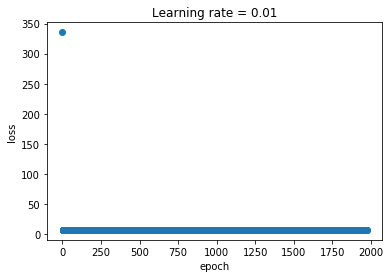

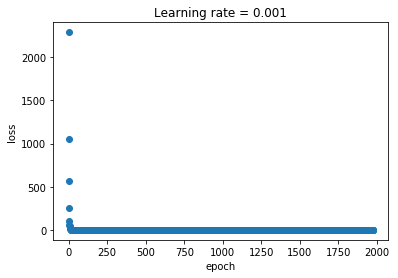

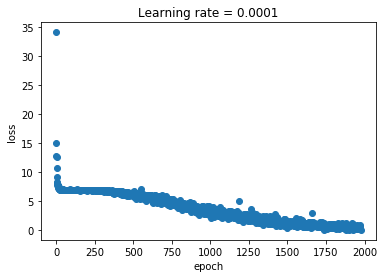

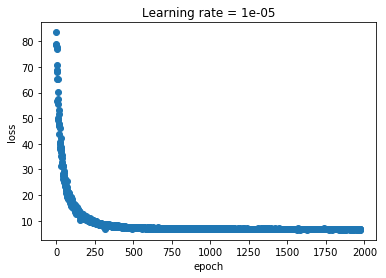

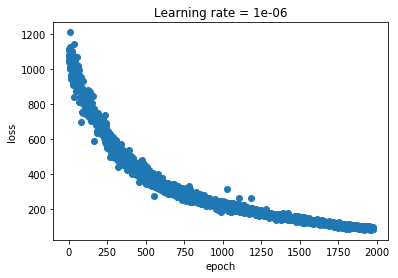

In [29]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
# print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))

### Insight:
From above graphs, we see that an optimal learning rate for this is around 1e-4 so will do random search about this point.

In [30]:
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [0.00039293643571672977]
for i in range(4):
    lrs.append(np.random.random()*1e-3)
x_train = imgnetX[:5000,:,:,:]
y_train = imgnetY[:5000]
for lr in lrs:
    print('Below result for lr = ', str(lr))
    model = encoderNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf, lossHistory = trainEncoder(model, x_train, y_train, optimizer, epochs = 15, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = model
        lrUsed = lr

Below result for lr =  0.00039293643571672977
Epoch 0, Iteration 0, loss = 288.0714
Epoch 0, Iteration 1, loss = 185.3286
Epoch 0, Iteration 2, loss = 120.5722
Epoch 0, Iteration 3, loss = 97.8783
Epoch 0, Iteration 4, loss = 74.9060
Epoch 0, Iteration 5, loss = 65.3935
Epoch 0, Iteration 6, loss = 47.2140
Epoch 0, Iteration 7, loss = 38.7878
Epoch 0, Iteration 8, loss = 29.2966
Epoch 0, Iteration 9, loss = 25.2890
Epoch 0, Iteration 10, loss = 16.3609
Epoch 0, Iteration 11, loss = 14.7196
Epoch 0, Iteration 12, loss = 11.1489
Epoch 0, Iteration 13, loss = 10.0946
Epoch 0, Iteration 14, loss = 9.4086
Epoch 0, Iteration 15, loss = 7.6384
Epoch 0, Iteration 16, loss = 7.5420
Epoch 0, Iteration 17, loss = 7.5581
Epoch 0, Iteration 18, loss = 7.8881
Epoch 0, Iteration 19, loss = 7.2661
Epoch 0, Iteration 20, loss = 7.0439
Epoch 0, Iteration 21, loss = 6.9192
Epoch 0, Iteration 22, loss = 7.1075
Epoch 0, Iteration 23, loss = 6.9338
Epoch 0, Iteration 24, loss = 7.1330
Epoch 0, Iteration 25,

Epoch 2, Iteration 61, loss = 6.7706
Epoch 2, Iteration 62, loss = 6.8100
Epoch 2, Iteration 63, loss = 6.7575
Epoch 2, Iteration 64, loss = 6.7550
Epoch 2, Iteration 65, loss = 6.7245
Epoch 2, Iteration 66, loss = 6.8560
Epoch 2, Iteration 67, loss = 6.7389
Epoch 2, Iteration 68, loss = 6.7474
Epoch 2, Iteration 69, loss = 6.7133
Epoch 2, Iteration 70, loss = 6.7804
Epoch 2, Iteration 71, loss = 6.8776
Epoch 2, Iteration 72, loss = 6.8210
Epoch 2, Iteration 73, loss = 6.8997
Epoch 2, Iteration 74, loss = 6.6601
Epoch 2, Iteration 75, loss = 6.8286
Epoch 2, Iteration 76, loss = 6.8366
Epoch 2, Iteration 77, loss = 6.7310
Epoch 2, Iteration 78, loss = 6.7428
Train percentage at epoch 2 is 0.0060
Epoch 3, Iteration 0, loss = 6.7358
Epoch 3, Iteration 1, loss = 6.7611
Epoch 3, Iteration 2, loss = 6.6849
Epoch 3, Iteration 3, loss = 6.7930
Epoch 3, Iteration 4, loss = 6.7849
Epoch 3, Iteration 5, loss = 6.8309
Epoch 3, Iteration 6, loss = 6.7121
Epoch 3, Iteration 7, loss = 6.7830
Epoch 3,

Epoch 5, Iteration 45, loss = 6.0921
Epoch 5, Iteration 46, loss = 6.2603
Epoch 5, Iteration 47, loss = 6.2992
Epoch 5, Iteration 48, loss = 6.0022
Epoch 5, Iteration 49, loss = 6.4211
Epoch 5, Iteration 50, loss = 6.3001
Epoch 5, Iteration 51, loss = 6.2336
Epoch 5, Iteration 52, loss = 6.2051
Epoch 5, Iteration 53, loss = 6.4602
Epoch 5, Iteration 54, loss = 6.3298
Epoch 5, Iteration 55, loss = 6.0398
Epoch 5, Iteration 56, loss = 6.1656
Epoch 5, Iteration 57, loss = 6.0915
Epoch 5, Iteration 58, loss = 6.1740
Epoch 5, Iteration 59, loss = 5.8175
Epoch 5, Iteration 60, loss = 6.1828
Epoch 5, Iteration 61, loss = 6.1276
Epoch 5, Iteration 62, loss = 6.4299
Epoch 5, Iteration 63, loss = 6.2456
Epoch 5, Iteration 64, loss = 6.1520
Epoch 5, Iteration 65, loss = 6.1568
Epoch 5, Iteration 66, loss = 6.0899
Epoch 5, Iteration 67, loss = 6.1909
Epoch 5, Iteration 68, loss = 6.3015
Epoch 5, Iteration 69, loss = 6.4874
Epoch 5, Iteration 70, loss = 6.3268
Epoch 5, Iteration 71, loss = 6.1497
E

Epoch 8, Iteration 29, loss = 4.6375
Epoch 8, Iteration 30, loss = 5.2338
Epoch 8, Iteration 31, loss = 5.3063
Epoch 8, Iteration 32, loss = 4.4923
Epoch 8, Iteration 33, loss = 5.2844
Epoch 8, Iteration 34, loss = 5.2234
Epoch 8, Iteration 35, loss = 5.0662
Epoch 8, Iteration 36, loss = 4.7927
Epoch 8, Iteration 37, loss = 5.3195
Epoch 8, Iteration 38, loss = 5.0052
Epoch 8, Iteration 39, loss = 5.5541
Epoch 8, Iteration 40, loss = 5.0319
Epoch 8, Iteration 41, loss = 5.2816
Epoch 8, Iteration 42, loss = 5.1118
Epoch 8, Iteration 43, loss = 4.7158
Epoch 8, Iteration 44, loss = 5.6629
Epoch 8, Iteration 45, loss = 5.2802
Epoch 8, Iteration 46, loss = 5.2694
Epoch 8, Iteration 47, loss = 5.0065
Epoch 8, Iteration 48, loss = 5.1347
Epoch 8, Iteration 49, loss = 5.4744
Epoch 8, Iteration 50, loss = 5.1394
Epoch 8, Iteration 51, loss = 5.0805
Epoch 8, Iteration 52, loss = 5.7364
Epoch 8, Iteration 53, loss = 5.1127
Epoch 8, Iteration 54, loss = 5.6093
Epoch 8, Iteration 55, loss = 5.1452
E

Epoch 11, Iteration 9, loss = 3.6739
Epoch 11, Iteration 10, loss = 3.9116
Epoch 11, Iteration 11, loss = 4.8583
Epoch 11, Iteration 12, loss = 4.5509
Epoch 11, Iteration 13, loss = 4.2665
Epoch 11, Iteration 14, loss = 4.5967
Epoch 11, Iteration 15, loss = 4.1351
Epoch 11, Iteration 16, loss = 4.8469
Epoch 11, Iteration 17, loss = 4.3704
Epoch 11, Iteration 18, loss = 4.8754
Epoch 11, Iteration 19, loss = 3.8590
Epoch 11, Iteration 20, loss = 4.7001
Epoch 11, Iteration 21, loss = 3.9964
Epoch 11, Iteration 22, loss = 4.1562
Epoch 11, Iteration 23, loss = 4.9483
Epoch 11, Iteration 24, loss = 4.3117
Epoch 11, Iteration 25, loss = 4.7017
Epoch 11, Iteration 26, loss = 4.5409
Epoch 11, Iteration 27, loss = 5.1280
Epoch 11, Iteration 28, loss = 4.8078
Epoch 11, Iteration 29, loss = 3.9322
Epoch 11, Iteration 30, loss = 5.0820
Epoch 11, Iteration 31, loss = 4.2060
Epoch 11, Iteration 32, loss = 4.8035
Epoch 11, Iteration 33, loss = 4.2911
Epoch 11, Iteration 34, loss = 4.1887
Epoch 11, Ite

Epoch 13, Iteration 67, loss = 3.8730
Epoch 13, Iteration 68, loss = 3.6119
Epoch 13, Iteration 69, loss = 3.9669
Epoch 13, Iteration 70, loss = 3.9562
Epoch 13, Iteration 71, loss = 2.7203
Epoch 13, Iteration 72, loss = 3.2232
Epoch 13, Iteration 73, loss = 3.8407
Epoch 13, Iteration 74, loss = 3.4390
Epoch 13, Iteration 75, loss = 2.9942
Epoch 13, Iteration 76, loss = 3.7896
Epoch 13, Iteration 77, loss = 3.5812
Epoch 13, Iteration 78, loss = 2.8863
Train percentage at epoch 13 is 0.4292
Epoch 14, Iteration 0, loss = 3.6204
Epoch 14, Iteration 1, loss = 3.9284
Epoch 14, Iteration 2, loss = 3.0974
Epoch 14, Iteration 3, loss = 3.5084
Epoch 14, Iteration 4, loss = 2.8843
Epoch 14, Iteration 5, loss = 3.9356
Epoch 14, Iteration 6, loss = 3.6120
Epoch 14, Iteration 7, loss = 3.8121
Epoch 14, Iteration 8, loss = 3.8950
Epoch 14, Iteration 9, loss = 3.6663
Epoch 14, Iteration 10, loss = 3.5190
Epoch 14, Iteration 11, loss = 3.4585
Epoch 14, Iteration 12, loss = 3.4475
Epoch 14, Iteration 1

Epoch 1, Iteration 45, loss = 6.8754
Epoch 1, Iteration 46, loss = 6.8549
Epoch 1, Iteration 47, loss = 6.9036
Epoch 1, Iteration 48, loss = 6.9098
Epoch 1, Iteration 49, loss = 6.8802
Epoch 1, Iteration 50, loss = 6.9332
Epoch 1, Iteration 51, loss = 6.8972
Epoch 1, Iteration 52, loss = 6.8962
Epoch 1, Iteration 53, loss = 6.8917
Epoch 1, Iteration 54, loss = 6.8929
Epoch 1, Iteration 55, loss = 6.8882
Epoch 1, Iteration 56, loss = 6.8934
Epoch 1, Iteration 57, loss = 6.8994
Epoch 1, Iteration 58, loss = 6.8519
Epoch 1, Iteration 59, loss = 6.8800
Epoch 1, Iteration 60, loss = 6.8760
Epoch 1, Iteration 61, loss = 6.8675
Epoch 1, Iteration 62, loss = 6.9130
Epoch 1, Iteration 63, loss = 6.8837
Epoch 1, Iteration 64, loss = 6.8947
Epoch 1, Iteration 65, loss = 6.8956
Epoch 1, Iteration 66, loss = 6.8893
Epoch 1, Iteration 67, loss = 6.8904
Epoch 1, Iteration 68, loss = 6.9017
Epoch 1, Iteration 69, loss = 6.8608
Epoch 1, Iteration 70, loss = 6.9001
Epoch 1, Iteration 71, loss = 6.8634
E

Epoch 4, Iteration 29, loss = 6.8029
Epoch 4, Iteration 30, loss = 6.8883
Epoch 4, Iteration 31, loss = 7.0445
Epoch 4, Iteration 32, loss = 6.9015
Epoch 4, Iteration 33, loss = 6.8311
Epoch 4, Iteration 34, loss = 6.8674
Epoch 4, Iteration 35, loss = 6.8611
Epoch 4, Iteration 36, loss = 6.8776
Epoch 4, Iteration 37, loss = 6.8676
Epoch 4, Iteration 38, loss = 6.8799
Epoch 4, Iteration 39, loss = 6.8622
Epoch 4, Iteration 40, loss = 6.8966
Epoch 4, Iteration 41, loss = 6.8989
Epoch 4, Iteration 42, loss = 6.8893
Epoch 4, Iteration 43, loss = 6.8932
Epoch 4, Iteration 44, loss = 6.8849
Epoch 4, Iteration 45, loss = 6.8559
Epoch 4, Iteration 46, loss = 6.8858
Epoch 4, Iteration 47, loss = 6.8861
Epoch 4, Iteration 48, loss = 6.8715
Epoch 4, Iteration 49, loss = 6.8694
Epoch 4, Iteration 50, loss = 6.8923
Epoch 4, Iteration 51, loss = 6.8776
Epoch 4, Iteration 52, loss = 6.8722
Epoch 4, Iteration 53, loss = 6.8919
Epoch 4, Iteration 54, loss = 6.8669
Epoch 4, Iteration 55, loss = 6.8925
E

Epoch 7, Iteration 13, loss = 6.8547
Epoch 7, Iteration 14, loss = 6.8666
Epoch 7, Iteration 15, loss = 6.8832
Epoch 7, Iteration 16, loss = 6.8171
Epoch 7, Iteration 17, loss = 6.8510
Epoch 7, Iteration 18, loss = 6.8626
Epoch 7, Iteration 19, loss = 6.8655
Epoch 7, Iteration 20, loss = 6.8505
Epoch 7, Iteration 21, loss = 6.8180
Epoch 7, Iteration 22, loss = 6.7989
Epoch 7, Iteration 23, loss = 6.8351
Epoch 7, Iteration 24, loss = 6.8537
Epoch 7, Iteration 25, loss = 6.8396
Epoch 7, Iteration 26, loss = 6.7612
Epoch 7, Iteration 27, loss = 6.8650
Epoch 7, Iteration 28, loss = 6.8556
Epoch 7, Iteration 29, loss = 6.7529
Epoch 7, Iteration 30, loss = 6.8684
Epoch 7, Iteration 31, loss = 6.7585
Epoch 7, Iteration 32, loss = 6.8912
Epoch 7, Iteration 33, loss = 6.8026
Epoch 7, Iteration 34, loss = 6.8213
Epoch 7, Iteration 35, loss = 6.7938
Epoch 7, Iteration 36, loss = 6.8381
Epoch 7, Iteration 37, loss = 6.8192
Epoch 7, Iteration 38, loss = 6.8927
Epoch 7, Iteration 39, loss = 6.8617
E

Epoch 9, Iteration 75, loss = 6.7494
Epoch 9, Iteration 76, loss = 6.7662
Epoch 9, Iteration 77, loss = 6.7511
Epoch 9, Iteration 78, loss = 6.8435
Train percentage at epoch 9 is 0.0048
Epoch 10, Iteration 0, loss = 6.7185
Epoch 10, Iteration 1, loss = 6.7960
Epoch 10, Iteration 2, loss = 6.7448
Epoch 10, Iteration 3, loss = 6.8603
Epoch 10, Iteration 4, loss = 6.7748
Epoch 10, Iteration 5, loss = 6.8368
Epoch 10, Iteration 6, loss = 6.8339
Epoch 10, Iteration 7, loss = 6.7722
Epoch 10, Iteration 8, loss = 6.7861
Epoch 10, Iteration 9, loss = 6.8140
Epoch 10, Iteration 10, loss = 6.7681
Epoch 10, Iteration 11, loss = 6.7422
Epoch 10, Iteration 12, loss = 6.7856
Epoch 10, Iteration 13, loss = 6.7889
Epoch 10, Iteration 14, loss = 6.7431
Epoch 10, Iteration 15, loss = 6.6798
Epoch 10, Iteration 16, loss = 6.8241
Epoch 10, Iteration 17, loss = 6.7283
Epoch 10, Iteration 18, loss = 6.7371
Epoch 10, Iteration 19, loss = 6.8321
Epoch 10, Iteration 20, loss = 6.8877
Epoch 10, Iteration 21, lo

Epoch 12, Iteration 53, loss = 6.7501
Epoch 12, Iteration 54, loss = 6.6863
Epoch 12, Iteration 55, loss = 6.6629
Epoch 12, Iteration 56, loss = 6.7436
Epoch 12, Iteration 57, loss = 6.7061
Epoch 12, Iteration 58, loss = 6.7928
Epoch 12, Iteration 59, loss = 6.6195
Epoch 12, Iteration 60, loss = 6.7248
Epoch 12, Iteration 61, loss = 6.8204
Epoch 12, Iteration 62, loss = 6.7538
Epoch 12, Iteration 63, loss = 6.7924
Epoch 12, Iteration 64, loss = 6.8194
Epoch 12, Iteration 65, loss = 6.7490
Epoch 12, Iteration 66, loss = 6.7723
Epoch 12, Iteration 67, loss = 6.7144
Epoch 12, Iteration 68, loss = 6.7847
Epoch 12, Iteration 69, loss = 6.7869
Epoch 12, Iteration 70, loss = 6.6941
Epoch 12, Iteration 71, loss = 6.7029
Epoch 12, Iteration 72, loss = 6.6589
Epoch 12, Iteration 73, loss = 6.7576
Epoch 12, Iteration 74, loss = 6.7905
Epoch 12, Iteration 75, loss = 6.6937
Epoch 12, Iteration 76, loss = 6.6937
Epoch 12, Iteration 77, loss = 6.7582
Epoch 12, Iteration 78, loss = 6.8656
Train percen

Epoch 0, Iteration 30, loss = 6.9042
Epoch 0, Iteration 31, loss = 6.9101
Epoch 0, Iteration 32, loss = 6.9036
Epoch 0, Iteration 33, loss = 6.9111
Epoch 0, Iteration 34, loss = 6.9054
Epoch 0, Iteration 35, loss = 6.8975
Epoch 0, Iteration 36, loss = 6.9045
Epoch 0, Iteration 37, loss = 6.8979
Epoch 0, Iteration 38, loss = 6.9080
Epoch 0, Iteration 39, loss = 6.9064
Epoch 0, Iteration 40, loss = 6.9046
Epoch 0, Iteration 41, loss = 6.9205
Epoch 0, Iteration 42, loss = 6.9075
Epoch 0, Iteration 43, loss = 6.9034
Epoch 0, Iteration 44, loss = 6.9079
Epoch 0, Iteration 45, loss = 6.9151
Epoch 0, Iteration 46, loss = 6.8945
Epoch 0, Iteration 47, loss = 6.9066
Epoch 0, Iteration 48, loss = 6.9027
Epoch 0, Iteration 49, loss = 6.9058
Epoch 0, Iteration 50, loss = 6.9059
Epoch 0, Iteration 51, loss = 6.9068
Epoch 0, Iteration 52, loss = 6.8910
Epoch 0, Iteration 53, loss = 6.9062
Epoch 0, Iteration 54, loss = 6.9068
Epoch 0, Iteration 55, loss = 6.9029
Epoch 0, Iteration 56, loss = 6.8954
E

Epoch 3, Iteration 13, loss = 6.8239
Epoch 3, Iteration 14, loss = 6.8931
Epoch 3, Iteration 15, loss = 6.8787
Epoch 3, Iteration 16, loss = 6.8128
Epoch 3, Iteration 17, loss = 6.8162
Epoch 3, Iteration 18, loss = 6.8514
Epoch 3, Iteration 19, loss = 6.8725
Epoch 3, Iteration 20, loss = 6.8671
Epoch 3, Iteration 21, loss = 6.9428
Epoch 3, Iteration 22, loss = 6.8553
Epoch 3, Iteration 23, loss = 6.8941
Epoch 3, Iteration 24, loss = 6.8784
Epoch 3, Iteration 25, loss = 6.8680
Epoch 3, Iteration 26, loss = 6.8618
Epoch 3, Iteration 27, loss = 6.8654
Epoch 3, Iteration 28, loss = 6.8973
Epoch 3, Iteration 29, loss = 6.8893
Epoch 3, Iteration 30, loss = 6.8896
Epoch 3, Iteration 31, loss = 6.8612
Epoch 3, Iteration 32, loss = 6.9087
Epoch 3, Iteration 33, loss = 6.8860
Epoch 3, Iteration 34, loss = 6.8885
Epoch 3, Iteration 35, loss = 6.8933
Epoch 3, Iteration 36, loss = 6.8472
Epoch 3, Iteration 37, loss = 6.8992
Epoch 3, Iteration 38, loss = 6.9062
Epoch 3, Iteration 39, loss = 6.8568
E

Epoch 5, Iteration 75, loss = 6.7551
Epoch 5, Iteration 76, loss = 6.6703
Epoch 5, Iteration 77, loss = 6.6407
Epoch 5, Iteration 78, loss = 6.7204
Train percentage at epoch 5 is 0.0072
Epoch 6, Iteration 0, loss = 6.5403
Epoch 6, Iteration 1, loss = 6.5774
Epoch 6, Iteration 2, loss = 6.8280
Epoch 6, Iteration 3, loss = 6.5944
Epoch 6, Iteration 4, loss = 6.6003
Epoch 6, Iteration 5, loss = 6.6776
Epoch 6, Iteration 6, loss = 6.8255
Epoch 6, Iteration 7, loss = 6.8337
Epoch 6, Iteration 8, loss = 6.8179
Epoch 6, Iteration 9, loss = 6.5956
Epoch 6, Iteration 10, loss = 6.6096
Epoch 6, Iteration 11, loss = 6.8282
Epoch 6, Iteration 12, loss = 6.7306
Epoch 6, Iteration 13, loss = 6.6461
Epoch 6, Iteration 14, loss = 6.3694
Epoch 6, Iteration 15, loss = 6.7519
Epoch 6, Iteration 16, loss = 6.7282
Epoch 6, Iteration 17, loss = 6.6547
Epoch 6, Iteration 18, loss = 6.7093
Epoch 6, Iteration 19, loss = 6.8558
Epoch 6, Iteration 20, loss = 6.8384
Epoch 6, Iteration 21, loss = 6.7070
Epoch 6, I

Epoch 8, Iteration 59, loss = 6.6830
Epoch 8, Iteration 60, loss = 6.6248
Epoch 8, Iteration 61, loss = 6.2902
Epoch 8, Iteration 62, loss = 6.6069
Epoch 8, Iteration 63, loss = 6.4162
Epoch 8, Iteration 64, loss = 6.4819
Epoch 8, Iteration 65, loss = 6.4197
Epoch 8, Iteration 66, loss = 6.4022
Epoch 8, Iteration 67, loss = 6.6017
Epoch 8, Iteration 68, loss = 6.6472
Epoch 8, Iteration 69, loss = 6.4784
Epoch 8, Iteration 70, loss = 6.3789
Epoch 8, Iteration 71, loss = 6.5109
Epoch 8, Iteration 72, loss = 6.3653
Epoch 8, Iteration 73, loss = 6.2195
Epoch 8, Iteration 74, loss = 6.2441
Epoch 8, Iteration 75, loss = 6.5353
Epoch 8, Iteration 76, loss = 6.4626
Epoch 8, Iteration 77, loss = 6.4888
Epoch 8, Iteration 78, loss = 6.4712
Train percentage at epoch 8 is 0.0228
Epoch 9, Iteration 0, loss = 6.2836
Epoch 9, Iteration 1, loss = 6.3764
Epoch 9, Iteration 2, loss = 6.0881
Epoch 9, Iteration 3, loss = 6.4918
Epoch 9, Iteration 4, loss = 6.5931
Epoch 9, Iteration 5, loss = 6.3241
Epoch 

Epoch 11, Iteration 39, loss = 6.1528
Epoch 11, Iteration 40, loss = 5.8339
Epoch 11, Iteration 41, loss = 5.5526
Epoch 11, Iteration 42, loss = 5.7061
Epoch 11, Iteration 43, loss = 5.6861
Epoch 11, Iteration 44, loss = 6.0684
Epoch 11, Iteration 45, loss = 5.7375
Epoch 11, Iteration 46, loss = 6.3245
Epoch 11, Iteration 47, loss = 5.8071
Epoch 11, Iteration 48, loss = 5.6057
Epoch 11, Iteration 49, loss = 5.8006
Epoch 11, Iteration 50, loss = 5.7192
Epoch 11, Iteration 51, loss = 6.0883
Epoch 11, Iteration 52, loss = 5.6486
Epoch 11, Iteration 53, loss = 6.2432
Epoch 11, Iteration 54, loss = 5.8217
Epoch 11, Iteration 55, loss = 5.7853
Epoch 11, Iteration 56, loss = 5.9941
Epoch 11, Iteration 57, loss = 5.5981
Epoch 11, Iteration 58, loss = 5.7850
Epoch 11, Iteration 59, loss = 5.6978
Epoch 11, Iteration 60, loss = 5.5963
Epoch 11, Iteration 61, loss = 6.1093
Epoch 11, Iteration 62, loss = 6.0665
Epoch 11, Iteration 63, loss = 5.9957
Epoch 11, Iteration 64, loss = 5.8121
Epoch 11, It

Epoch 14, Iteration 17, loss = 5.4308
Epoch 14, Iteration 18, loss = 5.2963
Epoch 14, Iteration 19, loss = 5.6448
Epoch 14, Iteration 20, loss = 5.5500
Epoch 14, Iteration 21, loss = 5.1584
Epoch 14, Iteration 22, loss = 5.6674
Epoch 14, Iteration 23, loss = 5.4067
Epoch 14, Iteration 24, loss = 5.0418
Epoch 14, Iteration 25, loss = 5.2476
Epoch 14, Iteration 26, loss = 4.9743
Epoch 14, Iteration 27, loss = 5.6397
Epoch 14, Iteration 28, loss = 5.3403
Epoch 14, Iteration 29, loss = 5.3238
Epoch 14, Iteration 30, loss = 5.4562
Epoch 14, Iteration 31, loss = 4.9787
Epoch 14, Iteration 32, loss = 5.2305
Epoch 14, Iteration 33, loss = 5.1219
Epoch 14, Iteration 34, loss = 5.0057
Epoch 14, Iteration 35, loss = 5.1036
Epoch 14, Iteration 36, loss = 4.8959
Epoch 14, Iteration 37, loss = 5.2859
Epoch 14, Iteration 38, loss = 5.2416
Epoch 14, Iteration 39, loss = 5.3850
Epoch 14, Iteration 40, loss = 5.4655
Epoch 14, Iteration 41, loss = 5.5746
Epoch 14, Iteration 42, loss = 4.8952
Epoch 14, It

Epoch 1, Iteration 77, loss = 6.8988
Epoch 1, Iteration 78, loss = 6.9176
Train percentage at epoch 1 is 0.0020
Epoch 2, Iteration 0, loss = 6.8962
Epoch 2, Iteration 1, loss = 6.8992
Epoch 2, Iteration 2, loss = 6.8985
Epoch 2, Iteration 3, loss = 6.9052
Epoch 2, Iteration 4, loss = 6.8990
Epoch 2, Iteration 5, loss = 6.9039
Epoch 2, Iteration 6, loss = 6.9079
Epoch 2, Iteration 7, loss = 6.9069
Epoch 2, Iteration 8, loss = 6.9039
Epoch 2, Iteration 9, loss = 6.9018
Epoch 2, Iteration 10, loss = 6.9004
Epoch 2, Iteration 11, loss = 6.8989
Epoch 2, Iteration 12, loss = 6.8989
Epoch 2, Iteration 13, loss = 6.9010
Epoch 2, Iteration 14, loss = 6.8995
Epoch 2, Iteration 15, loss = 6.8975
Epoch 2, Iteration 16, loss = 6.8987
Epoch 2, Iteration 17, loss = 6.8968
Epoch 2, Iteration 18, loss = 6.9021
Epoch 2, Iteration 19, loss = 6.8984
Epoch 2, Iteration 20, loss = 6.9001
Epoch 2, Iteration 21, loss = 6.8955
Epoch 2, Iteration 22, loss = 6.8949
Epoch 2, Iteration 23, loss = 6.9021
Epoch 2, I

Epoch 4, Iteration 61, loss = 6.8946
Epoch 4, Iteration 62, loss = 6.8847
Epoch 4, Iteration 63, loss = 6.8919
Epoch 4, Iteration 64, loss = 6.8921
Epoch 4, Iteration 65, loss = 6.8943
Epoch 4, Iteration 66, loss = 6.8939
Epoch 4, Iteration 67, loss = 6.8829
Epoch 4, Iteration 68, loss = 6.8889
Epoch 4, Iteration 69, loss = 6.8902
Epoch 4, Iteration 70, loss = 6.8904
Epoch 4, Iteration 71, loss = 6.8848
Epoch 4, Iteration 72, loss = 6.8839
Epoch 4, Iteration 73, loss = 6.8936
Epoch 4, Iteration 74, loss = 6.8929
Epoch 4, Iteration 75, loss = 6.8959
Epoch 4, Iteration 76, loss = 6.8957
Epoch 4, Iteration 77, loss = 6.8992
Epoch 4, Iteration 78, loss = 6.8901
Train percentage at epoch 4 is 0.0028
Epoch 5, Iteration 0, loss = 6.8891
Epoch 5, Iteration 1, loss = 6.8946
Epoch 5, Iteration 2, loss = 6.8878
Epoch 5, Iteration 3, loss = 6.8844
Epoch 5, Iteration 4, loss = 6.8948
Epoch 5, Iteration 5, loss = 6.8866
Epoch 5, Iteration 6, loss = 6.8886
Epoch 5, Iteration 7, loss = 6.8937
Epoch 5,

Epoch 7, Iteration 45, loss = 6.8844
Epoch 7, Iteration 46, loss = 6.8904
Epoch 7, Iteration 47, loss = 6.8815
Epoch 7, Iteration 48, loss = 6.8843
Epoch 7, Iteration 49, loss = 6.8838
Epoch 7, Iteration 50, loss = 6.8805
Epoch 7, Iteration 51, loss = 6.8869
Epoch 7, Iteration 52, loss = 6.8950
Epoch 7, Iteration 53, loss = 6.8823
Epoch 7, Iteration 54, loss = 6.8792
Epoch 7, Iteration 55, loss = 6.8793
Epoch 7, Iteration 56, loss = 6.8864
Epoch 7, Iteration 57, loss = 6.8870
Epoch 7, Iteration 58, loss = 6.8966
Epoch 7, Iteration 59, loss = 6.8816
Epoch 7, Iteration 60, loss = 6.8804
Epoch 7, Iteration 61, loss = 6.8838
Epoch 7, Iteration 62, loss = 6.8777
Epoch 7, Iteration 63, loss = 6.8952
Epoch 7, Iteration 64, loss = 6.8797
Epoch 7, Iteration 65, loss = 6.8901
Epoch 7, Iteration 66, loss = 6.8961
Epoch 7, Iteration 67, loss = 6.8898
Epoch 7, Iteration 68, loss = 6.8969
Epoch 7, Iteration 69, loss = 6.8907
Epoch 7, Iteration 70, loss = 6.8852
Epoch 7, Iteration 71, loss = 6.8905
E

Epoch 10, Iteration 27, loss = 6.8804
Epoch 10, Iteration 28, loss = 6.8878
Epoch 10, Iteration 29, loss = 6.8724
Epoch 10, Iteration 30, loss = 6.8890
Epoch 10, Iteration 31, loss = 6.8717
Epoch 10, Iteration 32, loss = 6.8741
Epoch 10, Iteration 33, loss = 6.8836
Epoch 10, Iteration 34, loss = 6.8788
Epoch 10, Iteration 35, loss = 6.8889
Epoch 10, Iteration 36, loss = 6.8895
Epoch 10, Iteration 37, loss = 6.8803
Epoch 10, Iteration 38, loss = 6.8815
Epoch 10, Iteration 39, loss = 6.8776
Epoch 10, Iteration 40, loss = 6.8730
Epoch 10, Iteration 41, loss = 6.8760
Epoch 10, Iteration 42, loss = 6.8859
Epoch 10, Iteration 43, loss = 6.8806
Epoch 10, Iteration 44, loss = 6.8779
Epoch 10, Iteration 45, loss = 6.8873
Epoch 10, Iteration 46, loss = 6.8815
Epoch 10, Iteration 47, loss = 6.8701
Epoch 10, Iteration 48, loss = 6.8790
Epoch 10, Iteration 49, loss = 6.8758
Epoch 10, Iteration 50, loss = 6.8721
Epoch 10, Iteration 51, loss = 6.8801
Epoch 10, Iteration 52, loss = 6.8735
Epoch 10, It

Epoch 13, Iteration 5, loss = 6.8770
Epoch 13, Iteration 6, loss = 6.8669
Epoch 13, Iteration 7, loss = 6.8718
Epoch 13, Iteration 8, loss = 6.8467
Epoch 13, Iteration 9, loss = 6.8798
Epoch 13, Iteration 10, loss = 6.8792
Epoch 13, Iteration 11, loss = 6.8640
Epoch 13, Iteration 12, loss = 6.8796
Epoch 13, Iteration 13, loss = 6.8720
Epoch 13, Iteration 14, loss = 6.8637
Epoch 13, Iteration 15, loss = 6.8776
Epoch 13, Iteration 16, loss = 6.8737
Epoch 13, Iteration 17, loss = 6.8660
Epoch 13, Iteration 18, loss = 6.8699
Epoch 13, Iteration 19, loss = 6.8802
Epoch 13, Iteration 20, loss = 6.8916
Epoch 13, Iteration 21, loss = 6.8641
Epoch 13, Iteration 22, loss = 6.8985
Epoch 13, Iteration 23, loss = 6.8705
Epoch 13, Iteration 24, loss = 6.8789
Epoch 13, Iteration 25, loss = 6.8714
Epoch 13, Iteration 26, loss = 6.8643
Epoch 13, Iteration 27, loss = 6.8750
Epoch 13, Iteration 28, loss = 6.8839
Epoch 13, Iteration 29, loss = 6.8729
Epoch 13, Iteration 30, loss = 6.8789
Epoch 13, Iterati

Epoch 0, Iteration 62, loss = 6.9023
Epoch 0, Iteration 63, loss = 6.9069
Epoch 0, Iteration 64, loss = 6.8999
Epoch 0, Iteration 65, loss = 6.9048
Epoch 0, Iteration 66, loss = 6.9049
Epoch 0, Iteration 67, loss = 6.9066
Epoch 0, Iteration 68, loss = 6.9004
Epoch 0, Iteration 69, loss = 6.9015
Epoch 0, Iteration 70, loss = 6.9061
Epoch 0, Iteration 71, loss = 6.9042
Epoch 0, Iteration 72, loss = 6.8982
Epoch 0, Iteration 73, loss = 6.9037
Epoch 0, Iteration 74, loss = 6.9082
Epoch 0, Iteration 75, loss = 6.9036
Epoch 0, Iteration 76, loss = 6.9049
Epoch 0, Iteration 77, loss = 6.9049
Epoch 0, Iteration 78, loss = 6.9067
Train percentage at epoch 0 is 0.0018
Epoch 1, Iteration 0, loss = 6.9032
Epoch 1, Iteration 1, loss = 6.9048
Epoch 1, Iteration 2, loss = 6.8977
Epoch 1, Iteration 3, loss = 6.9030
Epoch 1, Iteration 4, loss = 6.8846
Epoch 1, Iteration 5, loss = 6.9054
Epoch 1, Iteration 6, loss = 6.8999
Epoch 1, Iteration 7, loss = 6.8962
Epoch 1, Iteration 8, loss = 6.9026
Epoch 1, 

Epoch 3, Iteration 45, loss = 6.8929
Epoch 3, Iteration 46, loss = 6.8839
Epoch 3, Iteration 47, loss = 6.8942
Epoch 3, Iteration 48, loss = 6.8925
Epoch 3, Iteration 49, loss = 6.8891
Epoch 3, Iteration 50, loss = 6.8985
Epoch 3, Iteration 51, loss = 6.8950
Epoch 3, Iteration 52, loss = 6.8660
Epoch 3, Iteration 53, loss = 6.8934
Epoch 3, Iteration 54, loss = 6.8949
Epoch 3, Iteration 55, loss = 6.8948
Epoch 3, Iteration 56, loss = 6.8980
Epoch 3, Iteration 57, loss = 6.8911
Epoch 3, Iteration 58, loss = 6.8441
Epoch 3, Iteration 59, loss = 6.8889
Epoch 3, Iteration 60, loss = 6.8953
Epoch 3, Iteration 61, loss = 6.8944
Epoch 3, Iteration 62, loss = 6.8925
Epoch 3, Iteration 63, loss = 6.8974
Epoch 3, Iteration 64, loss = 6.8859
Epoch 3, Iteration 65, loss = 6.9046
Epoch 3, Iteration 66, loss = 6.8850
Epoch 3, Iteration 67, loss = 6.8978
Epoch 3, Iteration 68, loss = 6.8953
Epoch 3, Iteration 69, loss = 6.8871
Epoch 3, Iteration 70, loss = 6.8829
Epoch 3, Iteration 71, loss = 6.8968
E

Epoch 6, Iteration 29, loss = 6.8866
Epoch 6, Iteration 30, loss = 6.8916
Epoch 6, Iteration 31, loss = 6.8740
Epoch 6, Iteration 32, loss = 6.8848
Epoch 6, Iteration 33, loss = 6.8709
Epoch 6, Iteration 34, loss = 6.8782
Epoch 6, Iteration 35, loss = 6.8811
Epoch 6, Iteration 36, loss = 6.8910
Epoch 6, Iteration 37, loss = 6.8853
Epoch 6, Iteration 38, loss = 6.8837
Epoch 6, Iteration 39, loss = 6.8822
Epoch 6, Iteration 40, loss = 6.8864
Epoch 6, Iteration 41, loss = 6.8834
Epoch 6, Iteration 42, loss = 6.8844
Epoch 6, Iteration 43, loss = 6.8887
Epoch 6, Iteration 44, loss = 6.8902
Epoch 6, Iteration 45, loss = 6.8888
Epoch 6, Iteration 46, loss = 6.8782
Epoch 6, Iteration 47, loss = 6.8839
Epoch 6, Iteration 48, loss = 6.8821
Epoch 6, Iteration 49, loss = 6.8795
Epoch 6, Iteration 50, loss = 6.8799
Epoch 6, Iteration 51, loss = 6.8763
Epoch 6, Iteration 52, loss = 6.8854
Epoch 6, Iteration 53, loss = 6.8831
Epoch 6, Iteration 54, loss = 6.8713
Epoch 6, Iteration 55, loss = 6.8882
E

Epoch 9, Iteration 13, loss = 6.8819
Epoch 9, Iteration 14, loss = 6.8125
Epoch 9, Iteration 15, loss = 6.8764
Epoch 9, Iteration 16, loss = 6.8926
Epoch 9, Iteration 17, loss = 6.8764
Epoch 9, Iteration 18, loss = 6.8832
Epoch 9, Iteration 19, loss = 6.8614
Epoch 9, Iteration 20, loss = 6.8706
Epoch 9, Iteration 21, loss = 6.8715
Epoch 9, Iteration 22, loss = 6.8956
Epoch 9, Iteration 23, loss = 6.8784
Epoch 9, Iteration 24, loss = 6.8165
Epoch 9, Iteration 25, loss = 6.8731
Epoch 9, Iteration 26, loss = 6.7438
Epoch 9, Iteration 27, loss = 6.8789
Epoch 9, Iteration 28, loss = 6.8571
Epoch 9, Iteration 29, loss = 6.8790
Epoch 9, Iteration 30, loss = 6.8631
Epoch 9, Iteration 31, loss = 6.8735
Epoch 9, Iteration 32, loss = 6.8898
Epoch 9, Iteration 33, loss = 6.8650
Epoch 9, Iteration 34, loss = 6.8434
Epoch 9, Iteration 35, loss = 6.8644
Epoch 9, Iteration 36, loss = 6.8725
Epoch 9, Iteration 37, loss = 6.8502
Epoch 9, Iteration 38, loss = 6.8465
Epoch 9, Iteration 39, loss = 6.8855
E

Epoch 11, Iteration 71, loss = 6.8227
Epoch 11, Iteration 72, loss = 6.6942
Epoch 11, Iteration 73, loss = 6.8083
Epoch 11, Iteration 74, loss = 6.5561
Epoch 11, Iteration 75, loss = 6.8157
Epoch 11, Iteration 76, loss = 6.8013
Epoch 11, Iteration 77, loss = 6.7241
Epoch 11, Iteration 78, loss = 5.9881
Train percentage at epoch 11 is 0.0140
Epoch 12, Iteration 0, loss = 6.7801
Epoch 12, Iteration 1, loss = 6.7364
Epoch 12, Iteration 2, loss = 6.8222
Epoch 12, Iteration 3, loss = 6.5285
Epoch 12, Iteration 4, loss = 6.7691
Epoch 12, Iteration 5, loss = 6.7618
Epoch 12, Iteration 6, loss = 6.7983
Epoch 12, Iteration 7, loss = 6.8622
Epoch 12, Iteration 8, loss = 6.7838
Epoch 12, Iteration 9, loss = 6.5869
Epoch 12, Iteration 10, loss = 6.7133
Epoch 12, Iteration 11, loss = 6.7261
Epoch 12, Iteration 12, loss = 6.7790
Epoch 12, Iteration 13, loss = 6.7843
Epoch 12, Iteration 14, loss = 6.8378
Epoch 12, Iteration 15, loss = 6.5725
Epoch 12, Iteration 16, loss = 6.8155
Epoch 12, Iteration 1

Epoch 14, Iteration 49, loss = 5.9854
Epoch 14, Iteration 50, loss = 5.6398
Epoch 14, Iteration 51, loss = 6.2005
Epoch 14, Iteration 52, loss = 6.0909
Epoch 14, Iteration 53, loss = 6.0645
Epoch 14, Iteration 54, loss = 5.7610
Epoch 14, Iteration 55, loss = 6.1475
Epoch 14, Iteration 56, loss = 6.3856
Epoch 14, Iteration 57, loss = 6.2615
Epoch 14, Iteration 58, loss = 6.0994
Epoch 14, Iteration 59, loss = 6.3550
Epoch 14, Iteration 60, loss = 6.2889
Epoch 14, Iteration 61, loss = 5.9601
Epoch 14, Iteration 62, loss = 6.3276
Epoch 14, Iteration 63, loss = 6.2047
Epoch 14, Iteration 64, loss = 5.8768
Epoch 14, Iteration 65, loss = 5.9296
Epoch 14, Iteration 66, loss = 5.9109
Epoch 14, Iteration 67, loss = 5.9363
Epoch 14, Iteration 68, loss = 6.1264
Epoch 14, Iteration 69, loss = 5.9583
Epoch 14, Iteration 70, loss = 6.1328
Epoch 14, Iteration 71, loss = 6.5211
Epoch 14, Iteration 72, loss = 5.9680
Epoch 14, Iteration 73, loss = 5.8130
Epoch 14, Iteration 74, loss = 6.0962
Epoch 14, It

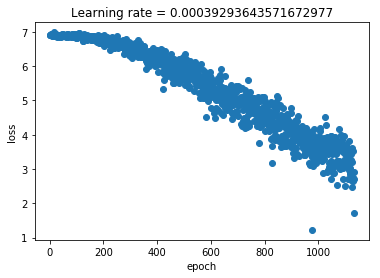

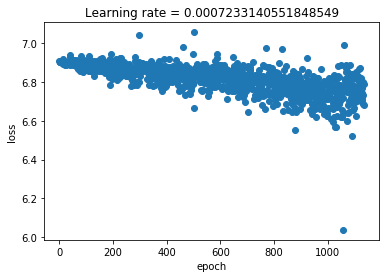

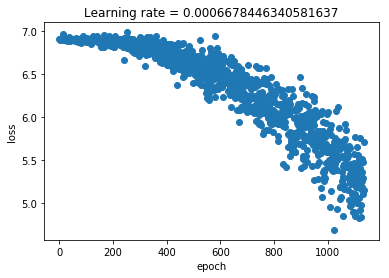

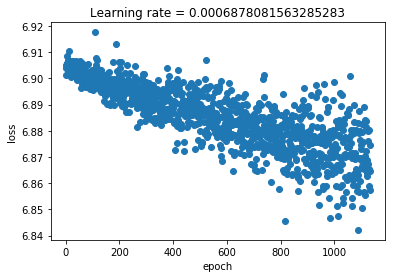

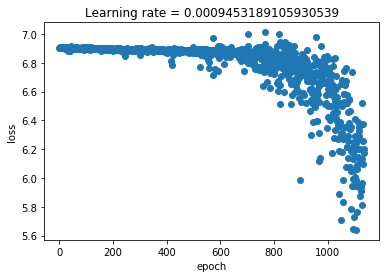

Lowest loss =  1.7304234504699707
lrUsed =  0.00039293643571672977


In [32]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist[50:]))),lossHist[50:], 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))
print('lrUsed = ', str(lrUsed))

In [8]:
shuffled_indices = np.random.permutation(imgnetX.shape[0])

train_indices = shuffled_indices[0:int(.9*(imgnetX.shape[0]))]
val_indices = shuffled_indices[int(.9*(imgnetX.shape[0])): int(.95*(imgnetX.shape[0]))]
test_indices = shuffled_indices[int(.95*(imgnetX.shape[0])):]

imgXtrain = imgnetX[train_indices, :, :, :]
imgYtrain = imgnetY[train_indices]

imgXval = imgnetX[val_indices, :, :, :]
imgYval = imgnetY[val_indices]

imgXtest = imgnetX[test_indices, :, :, :]
imgYtest = imgnetY[test_indices]

In [9]:
# Let us save to json file
json_data = {'train_indices':train_indices.tolist(), 'val_indices' :val_indices.tolist(), 'test_indices':test_indices.tolist()}
with open('imagenetData.json', 'w') as outfile:
    json.dump(json_data, outfile)

In [10]:
with open('imagenetData.json') as f:
    dwndata = json.load(f)
trainIndices = np.array(dwndata['train_indices'])
valIndices = np.array(dwndata['val_indices'])
testIndices = np.array(dwndata['test_indices'])
print('Num different = ', str(np.sum(trainIndices !=train_indices) + np.sum(valIndices !=val_indices) + np.sum(testIndices !=test_indices) ))

Num different =  0


In [27]:
print('Best lr used is ', str(lrUsed))
imgNetModel = bestModel
print_every = 100
optimizer = optim.Adam(imgNetModel.parameters(), lr = lrUsed)
modelPerf, lossHistory = trainEncoder(imgNetModel, imgXtrain, imgYtrain, optimizer, epochs = 60, noVal = True)

Best lr used is  0.0001


NameError: name 'imgXtrain' is not defined

In [ ]:
torch.save(imgNetModel, 'imgNetModel')

# References
[1] Amdal-Saevik, K. (2018). Keras U-Net starter - LB 0.277. 
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code

[2] Ho, D. J., Fu, C., Salama, P., Dunn, K. W., and Delp, E. J. (2017, July). Nuclei Segmentation of Fluorescence Microscopy Images Using Three Dimensional Convolutional Neural Networks. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2017 IEEE Conference on (pp. 834-842). IEEE.

[3] Kakade, A., and Dumbali, J. (2018, February). Identification of nerve in ultrasound images using U-net architecture. In 2018 International Conference on Communication information and Computing Technology (ICCICT) (pp. 1-6). IEEE.

[4] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C. W., and Heng, P. A. (2017). H-DenseUNet: Hybrid densely connected UNet for liver and liver tumor segmentation from CT volumes. arXiv preprint arXiv:1709.07330.

[5] Ronneberger, O., Fischer, P., and Brox, T. 
(2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[6] Pearce, C. Convolutional (2017). Neural Networks and the Analysis of Cancer Imagery.

[7] Imagenet. https://patrykchrabaszcz.github.io/Imagenet32/